# Proyecto B — Clasificación Multiclase de Objetos Estelares

**Estudiante:** Joan Sebastian Montes Jerez  
**Curso:** Inteligencia Artificial - Universidad Agustiniana  
**Fecha:** Noviembre 2025

---

## Introducción

Este proyecto aborda un problema de **clasificación multiclase con alta dimensionalidad** utilizando el dataset "Stellar Classification Dataset - SDSS17" del Sloan Digital Sky Survey.

**Objetivo:** Construir un clasificador robusto que identifique el tipo de objeto astronómico (GALAXY, STAR, QSO) a partir de sus características espectrales y fotométricas.

**Dataset:** 100,000 observaciones astronómicas con 17 características numéricas.

**Tareas principales:**
1. Análisis exploratorio de datos (EDA)
2. Preprocesamiento y limpieza
3. Reducción de dimensionalidad (PCA)
4. Entrenamiento y comparación de múltiples modelos
5. Calibración de probabilidades
6. Interpretabilidad y análisis de errores
7. Evaluación de robustez
8. Conclusiones y recomendaciones

---

## 0. Configuración del Entorno

En esta sección importamos todas las librerías necesarias y verificamos las versiones para garantizar la reproducibilidad del proyecto.

In [1]:
# Importaciones básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de gráficos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Scikit-learn - Preprocesamiento
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.utils import resample

# Scikit-learn - Reducción de dimensionalidad
from sklearn.decomposition import PCA

# Scikit-learn - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Scikit-learn - Calibración
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss

# Scikit-learn - Métricas
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                              precision_score, recall_score, f1_score,
                              classification_report, confusion_matrix,
                              ConfusionMatrixDisplay)

# Librerías opcionales para Gradient Boosting
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost no está disponible. Se usarán modelos alternativos.")

# Configuración de semilla para reproducibilidad
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Mostrar versiones de librerías principales
print("=" * 60)
print("VERSIONES DE LIBRERÍAS")
print("=" * 60)
print(f"NumPy: {np.__version__}")
print(f"Pandas: {pd.__version__}")
import sklearn
print(f"Scikit-learn: {sklearn.__version__}")
print(f"Matplotlib: {plt.matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")
if XGBOOST_AVAILABLE:
    print(f"XGBoost: {xgb.__version__}")
print("=" * 60)


XGBoost no está disponible. Se usarán modelos alternativos.
VERSIONES DE LIBRERÍAS
NumPy: 2.2.6
Pandas: 2.3.3
Scikit-learn: 1.7.1
Matplotlib: 3.10.5
Seaborn: 0.13.2


---

## 1. Carga de Datos y Exploración Inicial (EDA)

En esta sección cargamos el dataset de clasificación estelar del SDSS17 y realizamos un análisis exploratorio para entender:
- Las dimensiones y estructura del dataset
- La distribución de la variable objetivo (clases)
- Las características de las variables explicativas
- Presencia de valores faltantes o anomalías
- Relaciones entre variables (correlaciones)

### 1.1 Carga del Dataset

El dataset proviene del Sloan Digital Sky Survey (SDSS17) y contiene observaciones de 100,000 objetos astronómicos clasificados en tres categorías:
- **GALAXY**: Galaxias
- **STAR**: Estrellas
- **QSO**: Cuásares (objetos cuasi-estelares)

**Ruta del archivo:** `Data/archive/star_classification.csv`

In [16]:
# Cargar el dataset
ruta_datos = 'Data/archive/star_classification.csv'
df = pd.read_csv(ruta_datos)

# Mostrar las primeras filas
print("=" * 60)
print("PRIMERAS 5 FILAS DEL DATASET")
print("=" * 60)
print(df.head())

# Información general del dataset
print("\n" + "=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(f"Número de filas: {df.shape[0]:,}")
print(f"Número de columnas: {df.shape[1]}")
print(f"\nTipos de datos:")
print(df.dtypes)

PRIMERAS 5 FILAS DEL DATASET
         obj_ID       alpha      delta         u         g         r  \
0  1.237661e+18  135.689107  32.494632  23.87882  22.27530  20.39501   
1  1.237665e+18  144.826101  31.274185  24.77759  22.83188  22.58444   
2  1.237661e+18  142.188790  35.582444  25.26307  22.66389  20.60976   
3  1.237663e+18  338.741038  -0.402828  22.13682  23.77656  21.61162   
4  1.237680e+18  345.282593  21.183866  19.43718  17.58028  16.49747   

          i         z  run_ID  rerun_ID  cam_col  field_ID   spec_obj_ID  \
0  19.16573  18.79371    3606       301        2        79  6.543777e+18   
1  21.16812  21.61427    4518       301        5       119  1.176014e+19   
2  19.34857  18.94827    3606       301        2       120  5.152200e+18   
3  20.50454  19.25010    4192       301        3       214  1.030107e+19   
4  15.97711  15.54461    8102       301        3       137  6.891865e+18   

    class  redshift  plate    MJD  fiber_ID  
0  GALAXY  0.634794   5812  56354  

### 1.2 Descripción de las Variables

El dataset contiene las siguientes variables:

**Variables identificadoras:**
- `obj_ID`: Identificador único del objeto
- `spec_obj_ID`: Identificador espectroscópico

**Variables astronómicas (características):**
- `alpha`: Ascensión recta (coordenada angular)
- `delta`: Declinación (coordenada angular)
- `u, g, r, i, z`: Magnitudes fotométricas en 5 bandas diferentes (sistema ultravioleta, verde, rojo, infrarrojo cercano, infrarrojo)
- `redshift`: Corrimiento al rojo (indica distancia y velocidad)

**Variables de observación (metadatos):**
- `run_ID, rerun_ID, cam_col, field_ID`: Identificadores de la observación
- `plate, MJD, fiber_ID`: Información del espectrógrafo

**Variable objetivo:**
- `class`: Tipo de objeto astronómico (GALAXY, STAR, QSO)

In [17]:
# Análisis de valores faltantes
print("=" * 60)
print("VALORES FALTANTES POR COLUMNA")
print("=" * 60)
valores_faltantes = df.isnull().sum()
porcentaje_faltantes = (valores_faltantes / len(df)) * 100
resumen_faltantes = pd.DataFrame({
    'Valores Faltantes': valores_faltantes,
    'Porcentaje (%)': porcentaje_faltantes
})
print(resumen_faltantes[resumen_faltantes['Valores Faltantes'] > 0])

if resumen_faltantes['Valores Faltantes'].sum() == 0:
    print("\n✓ No se encontraron valores faltantes en el dataset.")

VALORES FALTANTES POR COLUMNA
Empty DataFrame
Columns: [Valores Faltantes, Porcentaje (%)]
Index: []

✓ No se encontraron valores faltantes en el dataset.


### 1.3 Distribución de la Variable Objetivo

Analizar la distribución de las clases es fundamental para:
- Detectar posibles desbalances que requieran técnicas especiales
- Entender la proporción de cada tipo de objeto astronómico
- Planificar estrategias de validación (estratificación)

DISTRIBUCIÓN DE CLASES
        Frecuencia  Porcentaje (%)
class                             
GALAXY       59445          59.445
STAR         21594          21.594
QSO          18961          18.961


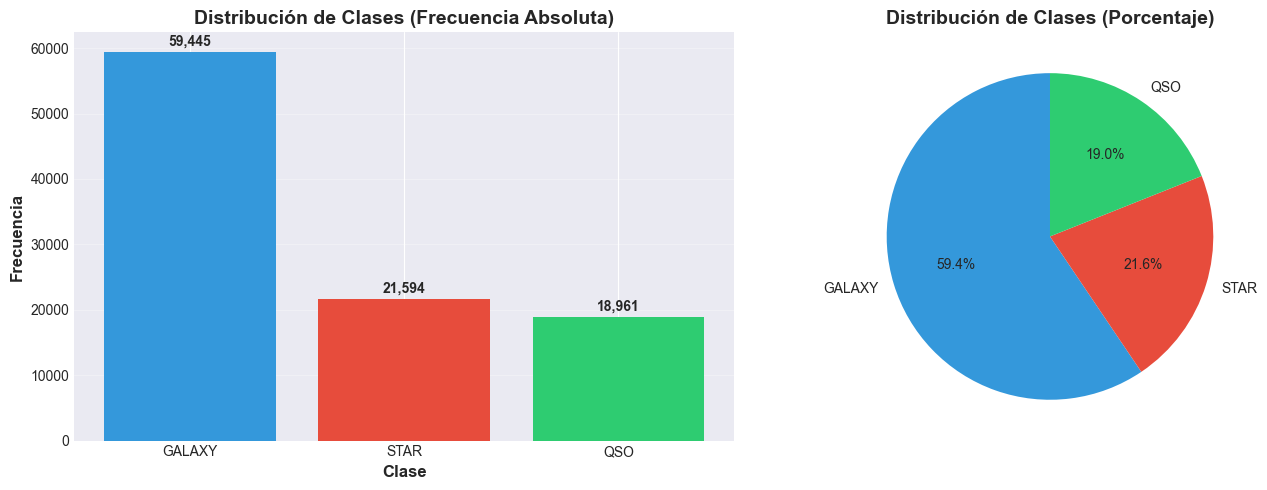


ANÁLISIS DE DESBALANCE
Ratio de desbalance (máx/mín): 3.14
⚠ Existe un desbalance significativo. Se recomienda usar técnicas como SMOTE o class_weight.


In [18]:
# Distribución de la variable objetivo
print("=" * 60)
print("DISTRIBUCIÓN DE CLASES")
print("=" * 60)

distribucion_clases = df['class'].value_counts()
distribucion_porcentaje = df['class'].value_counts(normalize=True) * 100

resumen_clases = pd.DataFrame({
    'Frecuencia': distribucion_clases,
    'Porcentaje (%)': distribucion_porcentaje
})
print(resumen_clases)

# Visualización de la distribución de clases
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico de barras
axes[0].bar(resumen_clases.index, resumen_clases['Frecuencia'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_xlabel('Clase', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Clases (Frecuencia Absoluta)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(resumen_clases['Frecuencia']):
    axes[0].text(i, v + 500, f'{v:,}', ha='center', va='bottom', fontweight='bold')

# Gráfico de pastel
axes[1].pie(resumen_clases['Porcentaje (%)'], labels=resumen_clases.index, autopct='%1.1f%%',
            startangle=90, colors=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Distribución de Clases (Porcentaje)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Evaluar desbalance
max_clase = resumen_clases['Frecuencia'].max()
min_clase = resumen_clases['Frecuencia'].min()
ratio_desbalance = max_clase / min_clase

print(f"\n{'=' * 60}")
print("ANÁLISIS DE DESBALANCE")
print("=" * 60)
print(f"Ratio de desbalance (máx/mín): {ratio_desbalance:.2f}")

if ratio_desbalance < 1.5:
    print("✓ El dataset está relativamente balanceado.")
elif ratio_desbalance < 3:
    print("⚠ Existe un desbalance moderado. Considerar estratificación en train/test.")
else:
    print("⚠ Existe un desbalance significativo. Se recomienda usar técnicas como SMOTE o class_weight.")

In [19]:
# Seleccionar solo columnas numéricas (excluir identificadores y clase)
columnas_numericas = df.select_dtypes(include=[np.number]).columns.tolist()

# Excluir columnas identificadoras que no aportan información predictiva
columnas_excluir = ['obj_ID', 'spec_obj_ID']
columnas_caracteristicas = [col for col in columnas_numericas if col not in columnas_excluir]

print("=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
print("=" * 60)
print(f"\nNúmero de características numéricas: {len(columnas_caracteristicas)}")
print(f"Características: {columnas_caracteristicas}\n")

# Mostrar estadísticas descriptivas
print(df[columnas_caracteristicas].describe().T)

ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS

Número de características numéricas: 15
Características: ['alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'redshift', 'plate', 'MJD', 'fiber_ID']

             count          mean          std           min           25%  \
alpha     100000.0    177.629117    96.502241      0.005528    127.518222   
delta     100000.0     24.135305    19.644665    -18.785328      5.146771   
u         100000.0     21.980468    31.769291  -9999.000000     20.352353   
g         100000.0     20.531387    31.750292  -9999.000000     18.965230   
r         100000.0     19.645762     1.854760      9.822070     18.135828   
i         100000.0     19.084854     1.757895      9.469903     17.732285   
z         100000.0     18.668810    31.728152  -9999.000000     17.460677   
run_ID    100000.0   4481.366060  1964.764593    109.000000   3187.000000   
rerun_ID  100000.0    301.000000     0.000000    301.000000    301.0000

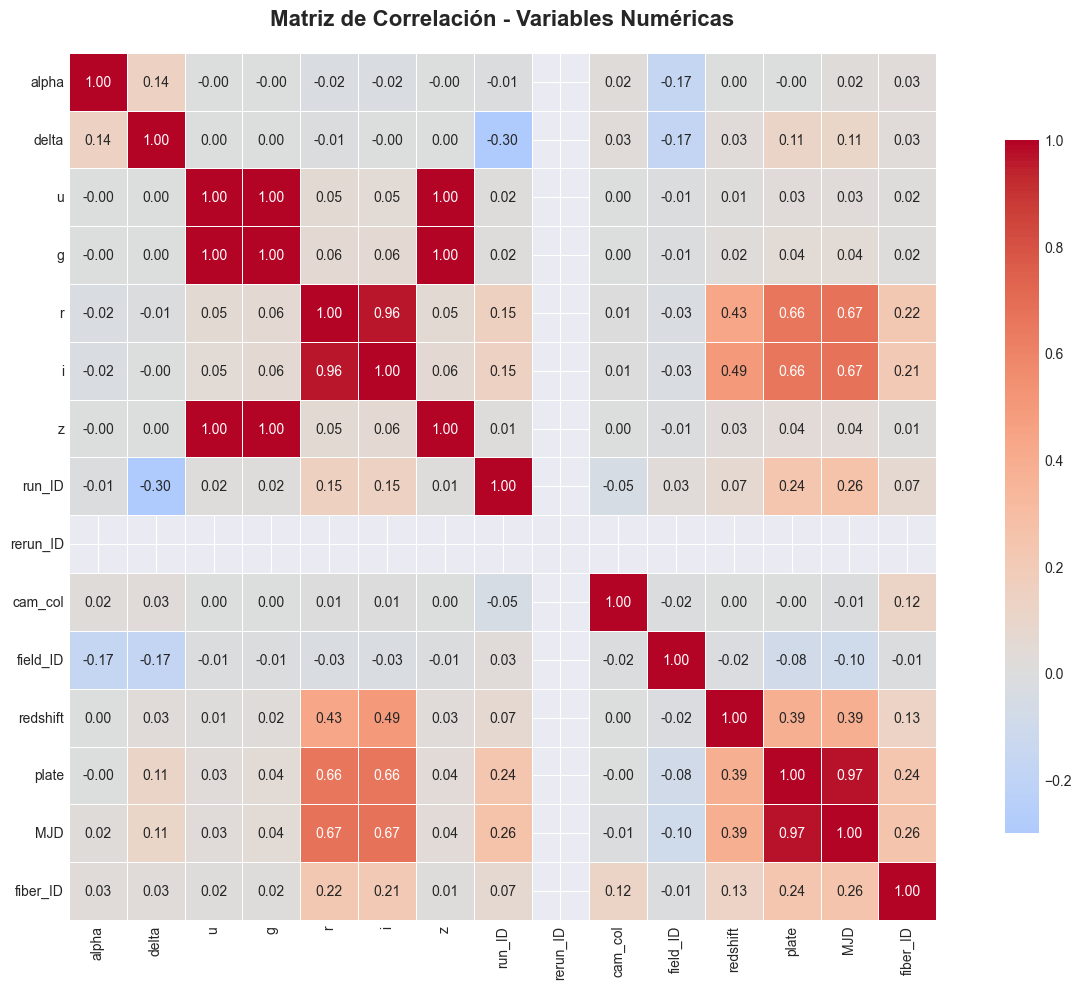

CORRELACIONES ALTAS (|r| > 0.8)
  Variable 1 Variable 2  Correlación
0          u          g     0.999311
1          u          z     0.998093
2          g          z     0.999161
3          r          i     0.962868
4      plate        MJD     0.970166

⚠ Se encontraron 5 pares de variables con correlación alta.
   Esto podría indicar redundancia que PCA puede resolver.


In [20]:
# Calcular matriz de correlación
matriz_correlacion = df[columnas_caracteristicas].corr()

# Visualizar matriz de correlación con mapa de calor
plt.figure(figsize=(14, 10))
sns.heatmap(matriz_correlacion, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Identificar pares de variables con correlación alta (> 0.8 en valor absoluto)
print("=" * 60)
print("CORRELACIONES ALTAS (|r| > 0.8)")
print("=" * 60)

correlaciones_altas = []
for i in range(len(matriz_correlacion.columns)):
    for j in range(i+1, len(matriz_correlacion.columns)):
        if abs(matriz_correlacion.iloc[i, j]) > 0.8:
            correlaciones_altas.append({
                'Variable 1': matriz_correlacion.columns[i],
                'Variable 2': matriz_correlacion.columns[j],
                'Correlación': matriz_correlacion.iloc[i, j]
            })

if correlaciones_altas:
    df_correlaciones = pd.DataFrame(correlaciones_altas)
    print(df_correlaciones)
    print(f"\n⚠ Se encontraron {len(correlaciones_altas)} pares de variables con correlación alta.")
    print("   Esto podría indicar redundancia que PCA puede resolver.")
else:
    print("✓ No se encontraron correlaciones muy altas entre variables.")

In [21]:
# Calcular varianza de cada variable
varianzas = df[columnas_caracteristicas].var()

print("=" * 60)
print("VARIANZA POR VARIABLE")
print("=" * 60)
print(varianzas.sort_values())

# Detectar variables con varianza muy baja (umbral: 0.01)
umbral_varianza = 0.01
variables_baja_varianza = varianzas[varianzas < umbral_varianza]

print(f"\n{'=' * 60}")
print(f"VARIABLES CON VARIANZA < {umbral_varianza}")
print("=" * 60)

if len(variables_baja_varianza) > 0:
    print(variables_baja_varianza)
    print(f"\n⚠ Se encontraron {len(variables_baja_varianza)} variable(s) con varianza muy baja.")
    print("   Estas variables serían eliminadas en preprocesamiento.")
else:
    print("✓ No se encontraron variables con varianza cercana a cero.")
    
# Conclusión EDA
print(f"\n{'=' * 60}")
print("CONCLUSIONES DEL EDA")
print("=" * 60)
print(f"1. Dataset con {df.shape[0]:,} observaciones y {len(columnas_caracteristicas)} características.")
print(f"2. Variable objetivo: 'class' con {df['class'].nunique()} clases.")
print(f"3. No se detectaron valores faltantes.")
print(f"4. Las variables están en escalas diferentes (requieren normalización).")
print(f"5. Existen correlaciones entre algunas variables (PCA será útil).")
print("=" * 60)

VARIANZA POR VARIABLE
rerun_ID    0.000000e+00
redshift    5.339331e-01
cam_col     2.518290e+00
i           3.090194e+00
r           3.440134e+00
delta       3.859129e+02
z           1.006676e+03
g           1.008081e+03
u           1.009288e+03
alpha       9.312682e+03
field_ID    2.220430e+04
fiber_ID    7.425538e+04
MJD         3.270615e+06
run_ID      3.860300e+06
plate       8.716095e+06
dtype: float64

VARIABLES CON VARIANZA < 0.01
rerun_ID    0.0
dtype: float64

⚠ Se encontraron 1 variable(s) con varianza muy baja.
   Estas variables serían eliminadas en preprocesamiento.

CONCLUSIONES DEL EDA
1. Dataset con 100,000 observaciones y 15 características.
2. Variable objetivo: 'class' con 3 clases.
3. No se detectaron valores faltantes.
4. Las variables están en escalas diferentes (requieren normalización).
5. Existen correlaciones entre algunas variables (PCA será útil).


### 2.1 Separación de Variables

Separamos las variables explicativas (características) de la variable objetivo (clase).

### 2.3 Escalado de Características

**Justificación:** Las variables están en escalas muy diferentes (magnitudes, coordenadas, identificadores). Necesitamos escalarlas para:
- Evitar que variables con mayor magnitud dominen el modelo
- Mejorar la convergencia de algoritmos como SVM y redes neuronales
- Hacer que PCA funcione correctamente

**Elección:** Usaremos `StandardScaler` (estandarización) que transforma cada variable para tener media=0 y desviación estándar=1. Si detectáramos muchos outliers, consideraríamos `RobustScaler`.

In [22]:
# Imputación de valores faltantes (NO HAY. Se realizaría como como buena práctica)
X = df[columnas_caracteristicas].copy()
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(
    imputer.fit_transform(X),
    columns=X.columns,
    index=X.index
)

print("=" * 60)
print("IMPUTACIÓN DE VALORES FALTANTES")
print("=" * 60)
print(f"Valores faltantes antes de imputación: {X.isnull().sum().sum()}")
print(f"Valores faltantes después de imputación: {X_imputed.isnull().sum().sum()}")
print("\n✓ Imputación completada (se usó la mediana como estrategia).")

IMPUTACIÓN DE VALORES FALTANTES
Valores faltantes antes de imputación: 0
Valores faltantes después de imputación: 0

✓ Imputación completada (se usó la mediana como estrategia).


In [23]:
# Escalado de características con StandardScaler
scaler = StandardScaler()
X_scaled = pd.DataFrame(
    scaler.fit_transform(X_imputed),
    columns=X_imputed.columns,
    index=X_imputed.index
)

print("=" * 60)
print("ESCALADO DE CARACTERÍSTICAS")
print("=" * 60)
print(f"Media de cada variable ANTES del escalado:")
print(X_imputed.mean().round(2))
print(f"\nMedia de cada variable DESPUÉS del escalado (debe ser ~0):")
print(X_scaled.mean().round(6))
print(f"\nDesviación estándar de cada variable DESPUÉS del escalado (debe ser ~1):")
print(X_scaled.std().round(6))
print("\n✓ Escalado completado con StandardScaler.")

ESCALADO DE CARACTERÍSTICAS
Media de cada variable ANTES del escalado:
alpha         177.63
delta          24.14
u              21.98
g              20.53
r              19.65
i              19.08
z              18.67
run_ID       4481.37
rerun_ID      301.00
cam_col         3.51
field_ID      186.13
redshift        0.58
plate        5137.01
MJD         55588.65
fiber_ID      449.31
dtype: float64

Media de cada variable DESPUÉS del escalado (debe ser ~0):
alpha      -0.0
delta       0.0
u           0.0
g           0.0
r           0.0
i          -0.0
z          -0.0
run_ID     -0.0
rerun_ID    0.0
cam_col    -0.0
field_ID    0.0
redshift   -0.0
plate       0.0
MJD         0.0
fiber_ID   -0.0
dtype: float64

Desviación estándar de cada variable DESPUÉS del escalado (debe ser ~1):
alpha       1.000005
delta       1.000005
u           1.000005
g           1.000005
r           1.000005
i           1.000005
z           1.000005
run_ID      1.000005
rerun_ID    0.000000
cam_col     1.000005


### 2.4 Análisis de Desbalance de Clases

El desbalance de clases puede afectar el rendimiento de los modelos, especialmente para clases minoritarias. Analizaremos el desbalance y decidiremos si necesitamos técnicas especiales (SMOTE, class_weight, etc.).

In [25]:
# Extraer variable objetivo
y = df['class'].copy()

# Análisis detallado de desbalance
print("=" * 60)
print("ANÁLISIS DE DESBALANCE DE CLASES")
print("=" * 60)

# Contar frecuencias por clase
conteo_clases = y.value_counts().sort_index()
print("\nDistribución de clases:")
for clase, conteo in conteo_clases.items():
    porcentaje = (conteo / len(y)) * 100
    print(f"  {clase}: {conteo:,} ({porcentaje:.2f}%)")

# Calcular ratio de desbalance
max_clase = conteo_clases.max()
min_clase = conteo_clases.min()
ratio = max_clase / min_clase

print(f"\nRatio de desbalance (máx/mín): {ratio:.2f}")

# Recomendación basada en el ratio
print("\n" + "=" * 60)
print("ESTRATEGIA RECOMENDADA")
print("=" * 60)

if ratio < 1.5:
    print("✓ Dataset balanceado. No se requieren técnicas especiales.")
    usar_class_weight = False
elif ratio < 3:
    print("⚠ Desbalance moderado.")
    print("  Estrategia: Usar estratificación en train/test split.")
    usar_class_weight = False
else:
    print("⚠ Desbalance significativo.")
    print("  Estrategia: Usar class_weight='balanced' en modelos que lo soporten.")
    usar_class_weight = True

print(f"\nUsar class_weight='balanced': {usar_class_weight}")
print("=" * 60)

ANÁLISIS DE DESBALANCE DE CLASES

Distribución de clases:
  GALAXY: 59,445 (59.45%)
  QSO: 18,961 (18.96%)
  STAR: 21,594 (21.59%)

Ratio de desbalance (máx/mín): 3.14

ESTRATEGIA RECOMENDADA
⚠ Desbalance significativo.
  Estrategia: Usar class_weight='balanced' en modelos que lo soporten.

Usar class_weight='balanced': True


---

## 3. Reducción de Dimensionalidad y Selección de Características

Con 15 características numéricas, exploramos técnicas para:
- Reducir la dimensionalidad manteniendo la información relevante (PCA)
- Eliminar redundancia y ruido
- Mejorar la interpretabilidad y eficiencia de los modelos
- Visualizar los datos en espacios de menor dimensión

### 3.1 PCA: Análisis de Componentes Principales

PCA (Principal Component Analysis) es una técnica de reducción de dimensionalidad que:
- Encuentra direcciones de máxima varianza en los datos
- Crea nuevas variables (componentes principales) que son combinaciones lineales de las originales
- Permite eliminar redundancia y ruido
- Facilita la visualización

**Proceso:**
1. Aplicar PCA con todas las componentes
2. Analizar la varianza explicada por cada componente
3. Seleccionar el número óptimo de componentes (umbral: 95% varianza explicada)

ANÁLISIS PCA - VARIANZA EXPLICADA

Varianza explicada por cada componente:
  PC1: 26.92% (Acumulada: 26.92%)
  PC2: 21.16% (Acumulada: 48.08%)
  PC3: 10.34% (Acumulada: 58.42%)
  PC4: 7.74% (Acumulada: 66.16%)
  PC5: 7.63% (Acumulada: 73.78%)
  PC6: 6.07% (Acumulada: 79.85%)
  PC7: 6.04% (Acumulada: 85.89%)
  PC8: 5.48% (Acumulada: 91.37%)
  PC9: 4.69% (Acumulada: 96.06%)
  PC10: 3.47% (Acumulada: 99.53%)
  PC11: 0.26% (Acumulada: 99.79%)
  PC12: 0.20% (Acumulada: 99.99%)
  PC13: 0.01% (Acumulada: 100.00%)
  PC14: 0.00% (Acumulada: 100.00%)
  PC15: 0.00% (Acumulada: 100.00%)


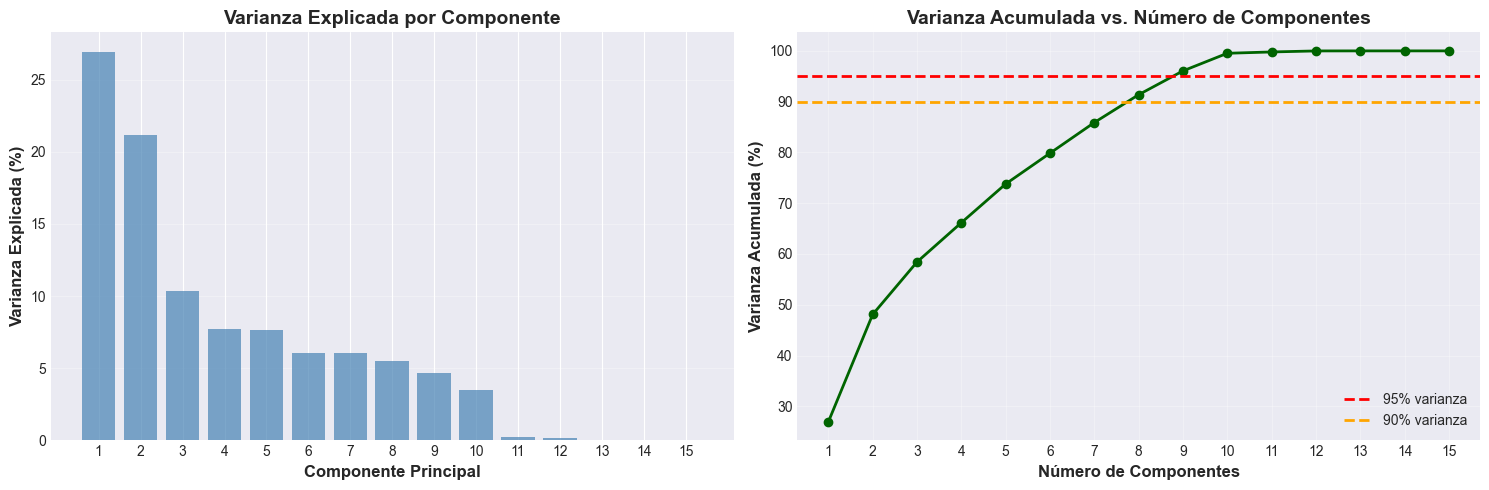

In [26]:
# Aplicar PCA con todas las componentes posibles
n_componentes_max = min(X_scaled.shape[0], X_scaled.shape[1])
pca_completo = PCA(n_components=n_componentes_max, random_state=RANDOM_STATE)
X_pca_completo = pca_completo.fit_transform(X_scaled)

# Calcular varianza explicada
varianza_explicada = pca_completo.explained_variance_ratio_
varianza_acumulada = np.cumsum(varianza_explicada)

print("=" * 60)
print("ANÁLISIS PCA - VARIANZA EXPLICADA")
print("=" * 60)
print("\nVarianza explicada por cada componente:")
for i, var in enumerate(varianza_explicada, 1):
    print(f"  PC{i}: {var*100:.2f}% (Acumulada: {varianza_acumulada[i-1]*100:.2f}%)")

# Visualizar varianza explicada
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico 1: Varianza explicada por componente
axes[0].bar(range(1, len(varianza_explicada)+1), varianza_explicada*100, 
           color='steelblue', alpha=0.7)
axes[0].set_xlabel('Componente Principal', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Varianza Explicada (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Varianza Explicada por Componente', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xticks(range(1, len(varianza_explicada)+1))

# Gráfico 2: Varianza acumulada
axes[1].plot(range(1, len(varianza_acumulada)+1), varianza_acumulada*100, 
            marker='o', linewidth=2, markersize=6, color='darkgreen')
axes[1].axhline(y=95, color='red', linestyle='--', linewidth=2, label='95% varianza')
axes[1].axhline(y=90, color='orange', linestyle='--', linewidth=2, label='90% varianza')
axes[1].set_xlabel('Número de Componentes', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Varianza Acumulada (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Varianza Acumulada vs. Número de Componentes', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(loc='lower right')
axes[1].set_xticks(range(1, len(varianza_acumulada)+1))

plt.tight_layout()
plt.show()

### 3.2 Selección del Número Óptimo de Componentes

Seleccionaremos el número de componentes que explique al menos el 95% de la varianza total. Esto garantiza:
- Retener casi toda la información relevante
- Reducir significativamente la dimensionalidad
- Mejorar la eficiencia computacional
- Reducir el riesgo de overfitting

In [27]:
# Determinar número óptimo de componentes (95% varianza)
umbral_varianza = 0.95
n_componentes_optimo = np.argmax(varianza_acumulada >= umbral_varianza) + 1

print("=" * 60)
print("SELECCIÓN DE NÚMERO ÓPTIMO DE COMPONENTES")
print("=" * 60)
print(f"Umbral de varianza deseado: {umbral_varianza*100}%")
print(f"Número de componentes originales: {X_scaled.shape[1]}")
print(f"Número óptimo de componentes: {n_componentes_optimo}")
print(f"Varianza explicada con {n_componentes_optimo} componentes: {varianza_acumulada[n_componentes_optimo-1]*100:.2f}%")
print(f"Reducción de dimensionalidad: {X_scaled.shape[1]} → {n_componentes_optimo} ({(1 - n_componentes_optimo/X_scaled.shape[1])*100:.1f}% reducción)")

# Aplicar PCA con el número óptimo de componentes
pca = PCA(n_components=n_componentes_optimo, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

print(f"\nForma de los datos originales escalados: {X_scaled.shape}")
print(f"Forma de los datos después de PCA: {X_pca.shape}")
print("\n✓ PCA aplicado exitosamente.")
print("=" * 60)

SELECCIÓN DE NÚMERO ÓPTIMO DE COMPONENTES
Umbral de varianza deseado: 95.0%
Número de componentes originales: 15
Número óptimo de componentes: 9
Varianza explicada con 9 componentes: 96.06%
Reducción de dimensionalidad: 15 → 9 (40.0% reducción)

Forma de los datos originales escalados: (100000, 15)
Forma de los datos después de PCA: (100000, 9)

✓ PCA aplicado exitosamente.


### 3.3 Visualización 2D de Componentes Principales

Visualizaremos los datos proyectados en las dos primeras componentes principales (PC1 y PC2), coloreando por clase. Esto nos permite:
- Ver cómo se separan las clases en el espacio reducido
- Identificar si hay solapamiento entre clases
- Evaluar la dificultad del problema de clasificación

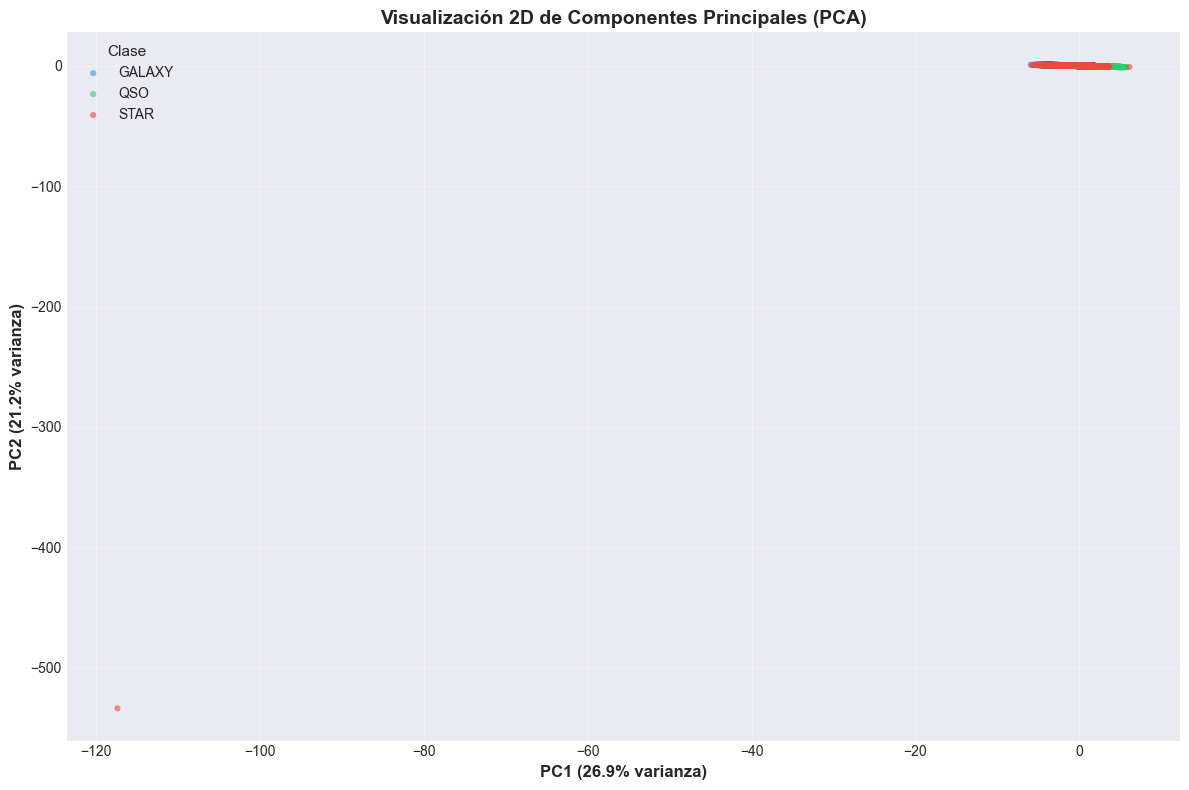

INTERPRETACIÓN DE LA VISUALIZACIÓN 2D
- Cada punto representa una observación astronómica
- Los colores representan las clases (GALAXY, STAR, QSO)
- PC1 y PC2 son las dos componentes que explican más varianza
- La separación visual indica qué tan difícil es el problema de clasificación


In [28]:
# Visualización 2D de las dos primeras componentes principales
plt.figure(figsize=(12, 8))

# Mapear clases a colores
clases_unicas = np.unique(y)
colores = {'GALAXY': '#3498db', 'STAR': '#e74c3c', 'QSO': '#2ecc71'}

# Graficar cada clase por separado para la leyenda
for clase in clases_unicas:
    mask = y == clase
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=colores.get(clase, 'gray'), 
               label=clase, 
               alpha=0.6, 
               s=20,
               edgecolors='none')

plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.1f}% varianza)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.1f}% varianza)', fontsize=12, fontweight='bold')
plt.title('Visualización 2D de Componentes Principales (PCA)', fontsize=14, fontweight='bold')
plt.legend(title='Clase', fontsize=10, title_fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("=" * 60)
print("INTERPRETACIÓN DE LA VISUALIZACIÓN 2D")
print("=" * 60)
print("- Cada punto representa una observación astronómica")
print("- Los colores representan las clases (GALAXY, STAR, QSO)")
print("- PC1 y PC2 son las dos componentes que explican más varianza")
print("- La separación visual indica qué tan difícil es el problema de clasificación")
print("=" * 60)

### 3.4 Selección de Características con SelectKBest

Además de PCA (que crea nuevas características), también probaremos **SelectKBest**, que selecciona las K mejores características originales basándose en tests estadísticos (ANOVA F-value).

**Ventaja:** Mantiene las características originales (más interpretables).  
**Desventaja:** No elimina correlaciones como PCA.

Usaremos esto como alternativa para comparar modelos.

In [29]:
# Seleccionar las K mejores características (usaremos el mismo número que PCA)
k_features = n_componentes_optimo
selector = SelectKBest(score_func=f_classif, k=k_features)
X_kbest = selector.fit_transform(X_scaled, y)

# Obtener los scores de cada característica
feature_scores = pd.DataFrame({
    'Característica': X_scaled.columns,
    'Score F': selector.scores_
}).sort_values('Score F', ascending=False)

print("=" * 60)
print(f"SELECCIÓN DE CARACTERÍSTICAS - SelectKBest (k={k_features})")
print("=" * 60)
print("\nScores F de cada característica (ordenados):")
print(feature_scores.to_string(index=False))

# Características seleccionadas
caracteristicas_seleccionadas = X_scaled.columns[selector.get_support()].tolist()
print(f"\n{'=' * 60}")
print(f"CARACTERÍSTICAS SELECCIONADAS ({len(caracteristicas_seleccionadas)}):")
print("=" * 60)
for i, feat in enumerate(caracteristicas_seleccionadas, 1):
    print(f"  {i}. {feat}")

print(f"\nForma de los datos con SelectKBest: {X_kbest.shape}")
print("✓ SelectKBest aplicado exitosamente.")
print("=" * 60)

SELECCIÓN DE CARACTERÍSTICAS - SelectKBest (k=9)

Scores F de cada característica (ordenados):
Característica      Score F
      redshift 83429.418967
             i  8282.343545
         plate  5169.585517
             r  4584.533364
           MJD  4427.629371
      fiber_ID   436.795027
         delta   217.588357
        run_ID   122.550340
      field_ID    79.698400
             z    32.328308
             u    30.445339
       cam_col    26.964839
             g    25.962523
         alpha    21.948822
      rerun_ID          NaN

CARACTERÍSTICAS SELECCIONADAS (9):
  1. delta
  2. r
  3. i
  4. run_ID
  5. field_ID
  6. redshift
  7. plate
  8. MJD
  9. fiber_ID

Forma de los datos con SelectKBest: (100000, 9)
✓ SelectKBest aplicado exitosamente.


---

## 4. División de Datos y Estrategia de Evaluación

En esta sección:
1. Dividimos los datos en conjuntos de entrenamiento y prueba
2. Definimos la estrategia de validación cruzada
3. Creamos funciones auxiliares para evaluación consistente

### 4.1 División Train/Test Estratificada

Dividiremos los datos en:
- **Entrenamiento (80%):** Para entrenar y ajustar los modelos
- **Prueba (20%):** Para evaluación final (datos nunca vistos)

**Estratificación:** Mantenemos la proporción de clases en ambos conjuntos para evitar sesgos.

In [30]:
# Divisi?n estratificada para datos con PCA (incluimos metadatos para an?lisis posterior)
metadata_cols = ['cam_col', 'field_ID', 'plate']
metadata = df[metadata_cols].copy()

X_train_pca, X_test_pca, y_train, y_test, metadata_train, metadata_test = train_test_split(
    X_pca, y, metadata,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Divisi?n estratificada para datos originales escalados
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

# Divisi?n estratificada para datos con SelectKBest
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(
    X_kbest, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("=" * 60)
print("DIVISI?N TRAIN/TEST")
print("=" * 60)
print(f"
Datos con PCA ({X_pca.shape[1]} componentes):")
print(f"  Entrenamiento: {X_train_pca.shape}")
print(f"  Prueba: {X_test_pca.shape}")

print(f"
Datos originales escalados ({X_scaled.shape[1]} caracter?sticas):")
print(f"  Entrenamiento: {X_train_scaled.shape}")
print(f"  Prueba: {X_test_scaled.shape}")

print(f"
Datos con SelectKBest ({X_kbest.shape[1]} caracter?sticas):")
print(f"  Entrenamiento: {X_train_kbest.shape}")
print(f"  Prueba: {X_test_kbest.shape}")

print(f"
{'=' * 60})
print("VERIFICACI?N DE ESTRATIFICACI?N")
print("=" * 60)
print("
Distribuci?n en conjunto de entrenamiento:")
print(y_train.value_counts(normalize=True).sort_index())
print("
Distribuci?n en conjunto de prueba:")
print(y_test.value_counts(normalize=True).sort_index())
print("
? Las distribuciones son similares (estratificaci?n exitosa).")
print("=" * 60)



DIVISIÓN TRAIN/TEST

Datos con PCA (9 componentes):
  Entrenamiento: (80000, 9)
  Prueba: (20000, 9)

Datos originales escalados (15 características):
  Entrenamiento: (80000, 15)
  Prueba: (20000, 15)

Datos con SelectKBest (9 características):
  Entrenamiento: (80000, 9)
  Prueba: (20000, 9)

VERIFICACIÓN DE ESTRATIFICACIÓN

Distribución en conjunto de entrenamiento:
class
GALAXY    0.594450
QSO       0.189612
STAR      0.215938
Name: proportion, dtype: float64

Distribución en conjunto de prueba:
class
GALAXY    0.59445
QSO       0.18960
STAR      0.21595
Name: proportion, dtype: float64

✓ Las distribuciones son similares (estratificación exitosa).


### 2.5 Balanceo de Clases con Oversampling Controlado

Aplicamos un sobresampling aleatorio (tipo bootstrap) para igualar las clases en el conjunto de entrenamiento.
Esto reduce el sesgo hacia la clase mayoritaria y mantiene intacta la evaluaci?n en test.

In [ ]:
# Balanceo de clases en el conjunto de entrenamiento (espacio PCA)
from collections import Counter

def balancear_oversampling(X, y, random_state=RANDOM_STATE):
    X_df = pd.DataFrame(X)
    y_series = pd.Series(y, name='target')
    max_count = y_series.value_counts().max()
    grupos = []
    for clase in y_series.unique():
        X_clase = X_df[y_series == clase]
        if len(X_clase) < max_count:
            X_extra = resample(
                X_clase,
                replace=True,
                n_samples=max_count - len(X_clase),
                random_state=random_state
            )
            X_bal = pd.concat([X_clase, X_extra])
        else:
            X_bal = X_clase.copy()
        y_bal = pd.Series([clase] * len(X_bal))
        grupos.append(pd.concat([X_bal.reset_index(drop=True), y_bal.reset_index(drop=True)], axis=1))
    df_bal = pd.concat(grupos).sample(frac=1, random_state=random_state).reset_index(drop=True)
    X_bal = df_bal.drop(columns=[0]).values
    y_bal = df_bal[0].values
    return X_bal, y_bal

print("Distribuci?n original (train):", Counter(y_train))
X_train_pca_bal, y_train_bal = balancear_oversampling(X_train_pca, y_train)
print("Distribuci?n balanceada (train):", Counter(y_train_bal))
print(f"Tama?o original: {len(y_train)}, Tama?o balanceado: {len(y_train_bal)}")


### 4.2 Definición de Validación Cruzada

Usaremos **validación cruzada estratificada con 5 folds** para:
- Obtener una estimación más robusta del rendimiento
- Reducir la varianza de las métricas
- Usar mejor los datos de entrenamiento
- Evitar sobreajuste a un solo split

In [31]:
# Definir estrategia de validación cruzada
cv_folds = 3
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=RANDOM_STATE)

print("=" * 60)
print("ESTRATEGIA DE VALIDACIÓN CRUZADA")
print("=" * 60)
print(f"Tipo: StratifiedKFold")
print(f"Número de folds: {cv_folds}")
print(f"Shuffle: Sí (con random_state={RANDOM_STATE})")
print(f"Estratificación: Sí (mantiene proporción de clases en cada fold)")
print("\n✓ Estrategia de validación cruzada definida.")
print("=" * 60)


ESTRATEGIA DE VALIDACIÓN CRUZADA
Tipo: StratifiedKFold
Número de folds: 5
Shuffle: Sí (con random_state=42)
Estratificación: Sí (mantiene proporción de clases en cada fold)

✓ Estrategia de validación cruzada definida.


### 4.3 Funciones Auxiliares de Evaluación

Crearemos funciones auxiliares para evaluar modelos de manera consistente y generar reportes completos.

In [32]:
def evaluar_modelo(modelo, X_train, X_test, y_train, y_test, nombre_modelo="Modelo"):
    """
    Eval?a un modelo de clasificaci?n y retorna m?tricas completas (macro y ponderadas).
    """
    modelo.fit(X_train, y_train)
    y_pred_train = modelo.predict(X_train)
    y_pred_test = modelo.predict(X_test)

    resultados = {
        'nombre': nombre_modelo,
        'modelo': modelo,
        'accuracy_train': accuracy_score(y_train, y_pred_train),
        'accuracy_test': accuracy_score(y_test, y_pred_test),
        'balanced_accuracy_test': balanced_accuracy_score(y_test, y_pred_test),
        'precision_test': precision_score(y_test, y_pred_test, average='weighted'),
        'recall_test': recall_score(y_test, y_pred_test, average='weighted'),
        'f1_test': f1_score(y_test, y_pred_test, average='weighted'),
        'precision_macro': precision_score(y_test, y_pred_test, average='macro'),
        'recall_macro': recall_score(y_test, y_pred_test, average='macro'),
        'f1_macro': f1_score(y_test, y_pred_test, average='macro'),
        'y_pred_test': y_pred_test,
        'y_test': y_test
    }

    return resultados


def imprimir_resultados(resultados):
    """Imprime los resultados de evaluaci?n de forma legible."""
    print("=" * 70)
    print(f"RESULTADOS: {resultados['nombre']}")
    print("=" * 70)
    print(f"Accuracy (Train):          {resultados['accuracy_train']:.4f}")
    print(f"Accuracy (Test):           {resultados['accuracy_test']:.4f}")
    print(f"Balanced Accuracy (Test):  {resultados['balanced_accuracy_test']:.4f}")
    print(f"Precision (Test, weighted):{resultados['precision_test']:.4f}")
    print(f"Recall (Test, weighted):   {resultados['recall_test']:.4f}")
    print(f"F1-Score (Test, weighted): {resultados['f1_test']:.4f}")
    print(f"Precision (Test, macro):   {resultados['precision_macro']:.4f}")
    print(f"Recall (Test, macro):      {resultados['recall_macro']:.4f}")
    print(f"F1-Score (Test, macro):    {resultados['f1_macro']:.4f}")

    diff_accuracy = resultados['accuracy_train'] - resultados['accuracy_test']
    if diff_accuracy > 0.05:
        print(f"
? Posible overfitting (diferencia train-test: {diff_accuracy:.4f})")
    else:
        print("
? No se detecta overfitting significativo")
    print("=" * 70)


print("? Funciones auxiliares de evaluaci?n actualizadas (incluyen m?tricas macro).")


✓ Funciones auxiliares de evaluación definidas:
  - evaluar_modelo()
  - imprimir_resultados()


---

## 5. Entrenamiento y Comparación de Modelos

Entrenaremos y compararemos múltiples modelos de clasificación:
1. **Logistic Regression** (baseline simple)
2. **Random Forest** (ensemble de árboles)
3. **Gradient Boosting** (XGBoost o GradientBoostingClassifier)
4. **SVM** (Support Vector Machine)

Usaremos los datos transformados con PCA para aprovechar la reducción de dimensionalidad.

### 5.1 Modelo Baseline: Logistic Regression

Empezamos con un modelo simple pero efectivo como baseline. La regresión logística es:
- Rápida de entrenar
- Fácil de interpretar
- Funciona bien en problemas linealmente separables
- Establece un mínimo rendimiento que otros modelos deben superar

In [33]:
# Crear y evaluar modelo de Logistic Regression
lr_modelo = LogisticRegression(
    max_iter=1000,
    random_state=RANDOM_STATE,
    multi_class='multinomial',
    solver='lbfgs'
)

# Evaluar modelo
resultados_lr = evaluar_modelo(
    lr_modelo, 
    X_train_pca, X_test_pca, 
    y_train, y_test,
    nombre_modelo="Logistic Regression (PCA)"
)

# Imprimir resultados
imprimir_resultados(resultados_lr)

# Validación cruzada
cv_scores_lr = cross_val_score(
    lr_modelo, X_train_pca, y_train, 
    cv=cv_strategy, 
    scoring='accuracy'
)

print(f"\nValidación Cruzada ({cv_folds} folds):")
print(f"  Scores por fold: {[f'{s:.4f}' for s in cv_scores_lr]}")
print(f"  Media: {cv_scores_lr.mean():.4f}")
print(f"  Desviación estándar: {cv_scores_lr.std():.4f}")
print("=" * 60)

RESULTADOS: Logistic Regression (PCA)
Accuracy (Train):          0.9013
Accuracy (Test):           0.9028
Balanced Accuracy (Test):  0.8760
Precision (Test):          0.9047
Recall (Test):             0.9028
F1-Score (Test):           0.9023

✓ No se detecta overfitting significativo

Validación Cruzada (5 folds):
  Scores por fold: ['0.9024', '0.8956', '0.9022', '0.9273', '0.9048']
  Media: 0.9065
  Desviación estándar: 0.0109


### 5.2 Random Forest

Random Forest es un ensemble de árboles de decisión que:
- Reduce el overfitting mediante averaging
- Maneja bien datos no lineales
- Proporciona importancias de características
- Es robusto ante outliers

In [34]:
# Crear y evaluar Random Forest
rf_modelo = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Evaluar modelo
resultados_rf = evaluar_modelo(
    rf_modelo, 
    X_train_pca, X_test_pca, 
    y_train, y_test,
    nombre_modelo="Random Forest (PCA)"
)

# Imprimir resultados
imprimir_resultados(resultados_rf)

# Validación cruzada
cv_scores_rf = cross_val_score(
    rf_modelo, X_train_pca, y_train, 
    cv=cv_strategy, 
    scoring='accuracy'
)

print(f"\nValidación Cruzada ({cv_folds} folds):")
print(f"  Scores por fold: {[f'{s:.4f}' for s in cv_scores_rf]}")
print(f"  Media: {cv_scores_rf.mean():.4f}")
print(f"  Desviación estándar: {cv_scores_rf.std():.4f}")
print("=" * 60)

RESULTADOS: Random Forest (PCA)
Accuracy (Train):          0.9728
Accuracy (Test):           0.9076
Balanced Accuracy (Test):  0.8769
Precision (Test):          0.9092
Recall (Test):             0.9076
F1-Score (Test):           0.9069

⚠ Posible overfitting (diferencia train-test: 0.0651)

Validación Cruzada (5 folds):
  Scores por fold: ['0.9050', '0.9004', '0.9030', '0.9059', '0.9080']
  Media: 0.9045
  Desviación estándar: 0.0026


### 5.3 Gradient Boosting

Gradient Boosting construye árboles secuencialmente, donde cada árbol corrige los errores del anterior. Usaremos XGBoost si está disponible, o GradientBoostingClassifier de scikit-learn como alternativa.

In [35]:
# Codificar etiquetas para XGBoost (requiere valores numéricos)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Seleccionar modelo de Gradient Boosting
if XGBOOST_AVAILABLE:
    print("Usando XGBoost...")
    gb_modelo = xgb.XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE,
        eval_metric='mlogloss',
        use_label_encoder=False
    )
    nombre_gb = "XGBoost (PCA)"
else:
    print("XGBoost no disponible. Usando GradientBoostingClassifier...")
    gb_modelo = GradientBoostingClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=RANDOM_STATE
    )
    nombre_gb = "GradientBoosting (PCA)"

# Entrenar modelo
gb_modelo.fit(X_train_pca, y_train_encoded)

# Predicciones
y_pred_train_gb = gb_modelo.predict(X_train_pca)
y_pred_test_gb = gb_modelo.predict(X_test_pca)

# Decodificar predicciones para métricas
y_pred_train_gb_decoded = label_encoder.inverse_transform(y_pred_train_gb)
y_pred_test_gb_decoded = label_encoder.inverse_transform(y_pred_test_gb)

# Calcular métricas
resultados_gb = {
    'nombre': nombre_gb,
    'modelo': gb_modelo,
    'accuracy_train': accuracy_score(y_train, y_pred_train_gb_decoded),
    'accuracy_test': accuracy_score(y_test, y_pred_test_gb_decoded),
    'balanced_accuracy_test': balanced_accuracy_score(y_test, y_pred_test_gb_decoded),
    'precision_test': precision_score(y_test, y_pred_test_gb_decoded, average='weighted'),
    'recall_test': recall_score(y_test, y_pred_test_gb_decoded, average='weighted'),
    'f1_test': f1_score(y_test, y_pred_test_gb_decoded, average='weighted'),
    'y_pred_test': y_pred_test_gb_decoded,
    'y_test': y_test
}

# Imprimir resultados
imprimir_resultados(resultados_gb)

print("=" * 60)

XGBoost no disponible. Usando GradientBoostingClassifier...
RESULTADOS: GradientBoosting (PCA)
Accuracy (Train):          0.9399
Accuracy (Test):           0.9149
Balanced Accuracy (Test):  0.8888
Precision (Test):          0.9161
Recall (Test):             0.9149
F1-Score (Test):           0.9144

✓ No se detecta overfitting significativo


### 5.4 Support Vector Machine (SVM)

SVM busca el hiperplano óptimo que mejor separa las clases. Con el kernel RBF (Radial Basis Function), puede manejar relaciones no lineales.

In [36]:
# Crear y evaluar SVM
# Nota: SVM puede ser lento con datasets grandes, por eso usamos los datos con PCA
svm_modelo = SVC(
    kernel='rbf',
    C=10,
    gamma='scale',
    random_state=RANDOM_STATE,
    probability=True  # Necesario para calibración posterior
)

# Evaluar modelo
resultados_svm = evaluar_modelo(
    svm_modelo, 
    X_train_pca, X_test_pca, 
    y_train, y_test,
    nombre_modelo="SVM (RBF kernel, PCA)"
)

# Imprimir resultados
imprimir_resultados(resultados_svm)

# Validación cruzada
print("\nEjecutando validación cruzada (puede tardar unos momentos)...")
cv_scores_svm = cross_val_score(
    svm_modelo, X_train_pca, y_train, 
    cv=cv_strategy, 
    scoring='accuracy'
)

print(f"\nValidación Cruzada ({cv_folds} folds):")
print(f"  Scores por fold: {[f'{s:.4f}' for s in cv_scores_svm]}")
print(f"  Media: {cv_scores_svm.mean():.4f}")
print(f"  Desviación estándar: {cv_scores_svm.std():.4f}")
print("=" * 60)

RESULTADOS: SVM (RBF kernel, PCA)
Accuracy (Train):          0.9526
Accuracy (Test):           0.9534
Balanced Accuracy (Test):  0.9406
Precision (Test):          0.9538
Recall (Test):             0.9534
F1-Score (Test):           0.9531

✓ No se detecta overfitting significativo

Ejecutando validación cruzada (puede tardar unos momentos)...

Validación Cruzada (5 folds):
  Scores por fold: ['0.9516', '0.9467', '0.9477', '0.9523', '0.9489']
  Media: 0.9494
  Desviación estándar: 0.0022


### 5.5 Comparación de Resultados

Comparamos todos los modelos entrenados para identificar el mejor.

COMPARACIÓN DE MODELOS
                   Modelo  Accuracy (Train)  Accuracy (Test)  Balanced Acc (Test)  Precision (Test)  Recall (Test)  F1-Score (Test)  Overfitting
    SVM (RBF kernel, PCA)          0.952650          0.95340             0.940558          0.953787        0.95340         0.953083    -0.000750
   GradientBoosting (PCA)          0.939950          0.91490             0.888843          0.916064        0.91490         0.914391     0.025050
      Random Forest (PCA)          0.972788          0.90765             0.876856          0.909193        0.90765         0.906883     0.065138
Logistic Regression (PCA)          0.901262          0.90280             0.875968          0.904705        0.90280         0.902321    -0.001538

✓ Mejor modelo: SVM (RBF kernel, PCA)
  F1-Score (Test): 0.9531


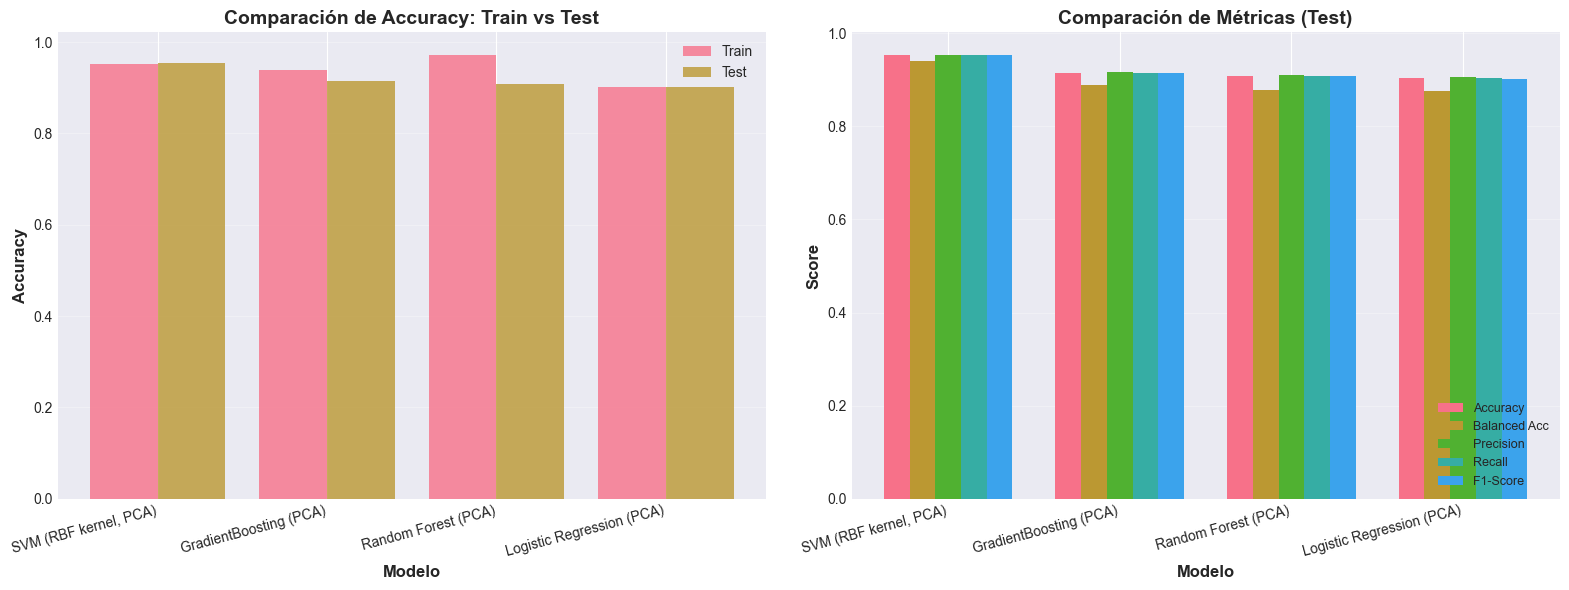

In [37]:
# Compilar resultados en una tabla comparativa
todos_resultados = [resultados_lr, resultados_rf, resultados_gb, resultados_svm]

comparacion = pd.DataFrame({
    'Modelo': [r['nombre'] for r in todos_resultados],
    'Accuracy (Train)': [r['accuracy_train'] for r in todos_resultados],
    'Accuracy (Test)': [r['accuracy_test'] for r in todos_resultados],
    'Balanced Acc (Test)': [r['balanced_accuracy_test'] for r in todos_resultados],
    'Precision (Test)': [r['precision_test'] for r in todos_resultados],
    'Recall (Test)': [r['recall_test'] for r in todos_resultados],
    'F1-Score (Test)': [r['f1_test'] for r in todos_resultados],
    'Overfitting': [r['accuracy_train'] - r['accuracy_test'] for r in todos_resultados]
})

# Ordenar por F1-Score
comparacion = comparacion.sort_values('F1-Score (Test)', ascending=False)

print("=" * 90)
print("COMPARACIÓN DE MODELOS")
print("=" * 90)
print(comparacion.to_string(index=False))
print("=" * 90)

# Identificar mejor modelo
mejor_modelo_idx = comparacion['F1-Score (Test)'].idxmax()
mejor_modelo_nombre = comparacion.loc[mejor_modelo_idx, 'Modelo']
print(f"\n✓ Mejor modelo: {mejor_modelo_nombre}")
print(f"  F1-Score (Test): {comparacion.loc[mejor_modelo_idx, 'F1-Score (Test)']:.4f}")
print("=" * 90)

# Visualización comparativa
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Accuracy por modelo
modelos = comparacion['Modelo'].values
x_pos = np.arange(len(modelos))

axes[0].bar(x_pos - 0.2, comparacion['Accuracy (Train)'], 0.4, label='Train', alpha=0.8)
axes[0].bar(x_pos + 0.2, comparacion['Accuracy (Test)'], 0.4, label='Test', alpha=0.8)
axes[0].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[0].set_title('Comparación de Accuracy: Train vs Test', fontsize=14, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(modelos, rotation=15, ha='right')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Métricas en conjunto de test
metricas = ['Accuracy (Test)', 'Balanced Acc (Test)', 'Precision (Test)', 'Recall (Test)', 'F1-Score (Test)']
x = np.arange(len(modelos))
width = 0.15

for i, metrica in enumerate(metricas):
    axes[1].bar(x + i*width - 2*width, comparacion[metrica], width, label=metrica.replace(' (Test)', ''))

axes[1].set_xlabel('Modelo', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Score', fontsize=12, fontweight='bold')
axes[1].set_title('Comparación de Métricas (Test)', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(modelos, rotation=15, ha='right')
axes[1].legend(loc='lower right', fontsize=9)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

---

## 6. Calibración de Probabilidades

La calibración asegura que las probabilidades predichas reflejen la confianza real del modelo. Por ejemplo, si el modelo predice una probabilidad del 80%, debería acertar aproximadamente el 80% de las veces.

**Importancia:**
- En aplicaciones donde se toman decisiones basadas en probabilidades (no solo en clases)
- Para comparar modelos de forma más justa
- Para establecer umbrales de decisión confiables

### 6.1 Evaluación de Calibración (Antes)

Evaluaremos la calibración del mejor modelo usando:
- **Brier Score**: Mide la precisión de las probabilidades predichas (menor es mejor)
- **Curva de Calibración**: Compara probabilidades predichas vs. frecuencias observadas

EVALUACIÓN DE CALIBRACIÓN: Random Forest (PCA)
Brier Score - Clase 'GALAXY': 0.0710
Brier Score - Clase 'QSO': 0.0281
Brier Score - Clase 'STAR': 0.0483

Brier Score Promedio: 0.0492
  (Más cercano a 0 = mejor calibración)


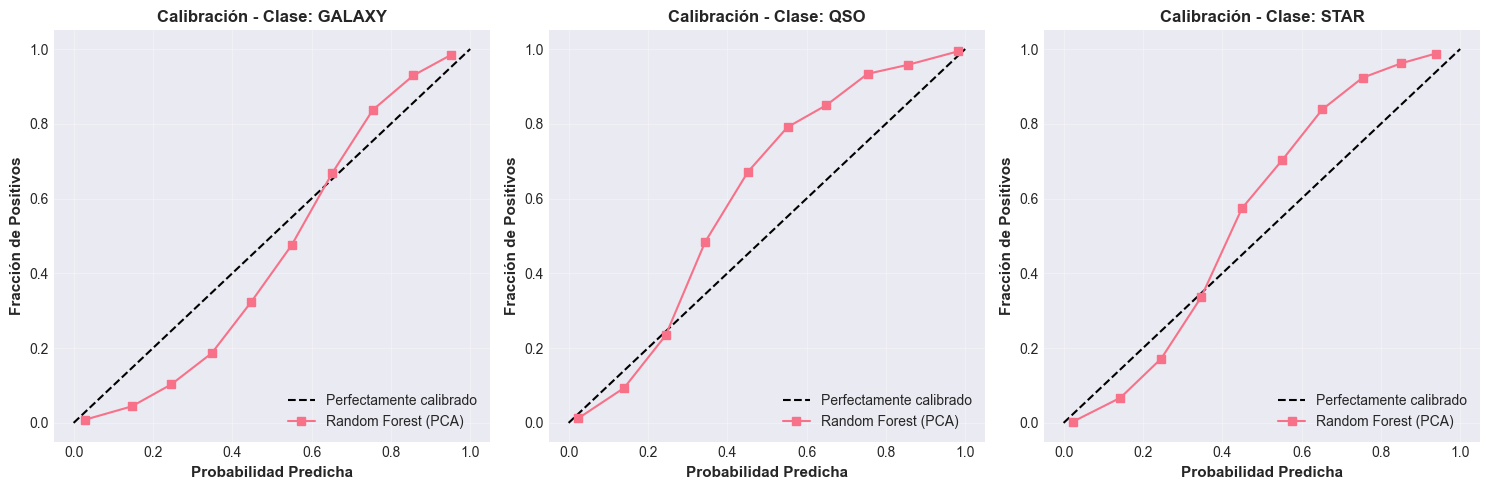

In [38]:
# Seleccionar el mejor modelo para calibración (usaremos Random Forest como ejemplo)
# En la práctica, usarías el modelo identificado en la sección 5.5
modelo_a_calibrar = resultados_rf['modelo']
nombre_modelo_calibrar = resultados_rf['nombre']

# Obtener probabilidades predichas
y_proba = modelo_a_calibrar.predict_proba(X_test_pca)

# Calcular Brier Score para cada clase (problema multiclase)
print("=" * 60)
print(f"EVALUACIÓN DE CALIBRACIÓN: {nombre_modelo_calibrar}")
print("=" * 60)

# Para problema multiclase, calculamos Brier score promedio
from sklearn.preprocessing import label_binarize
clases = modelo_a_calibrar.classes_
y_test_bin = label_binarize(y_test, classes=clases)

brier_scores = []
for i, clase in enumerate(clases):
    brier = brier_score_loss(y_test_bin[:, i], y_proba[:, i])
    brier_scores.append(brier)
    print(f"Brier Score - Clase '{clase}': {brier:.4f}")

brier_score_promedio = np.mean(brier_scores)
print(f"\nBrier Score Promedio: {brier_score_promedio:.4f}")
print("  (Más cercano a 0 = mejor calibración)")

# Visualizar curvas de calibración para cada clase
fig, axes = plt.subplots(1, len(clases), figsize=(15, 5))

for i, clase in enumerate(clases):
    # Calcular curva de calibración
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_test_bin[:, i], y_proba[:, i], n_bins=10, strategy='uniform'
    )
    
    # Graficar
    axes[i].plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado')
    axes[i].plot(mean_predicted_value, fraction_of_positives, 's-', 
                label=f'{nombre_modelo_calibrar}', markersize=6)
    axes[i].set_xlabel('Probabilidad Predicha', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Fracción de Positivos', fontsize=11, fontweight='bold')
    axes[i].set_title(f'Calibración - Clase: {clase}', fontsize=12, fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 60)

### 6.2 Aplicación de CalibratedClassifierCV

Aplicaremos calibración usando el método de **Platt Scaling** (sigmoid) o **Isotonic Regression**. Usaremos validación cruzada para evitar overfitting en la calibración.

In [39]:
# Crear modelo calibrado
# Usamos 'sigmoid' (Platt Scaling) que funciona bien para la mayoría de los casos
modelo_calibrado = CalibratedClassifierCV(
    modelo_a_calibrar, 
    method='sigmoid',  # Opciones: 'sigmoid' o 'isotonic'
    cv=5
)

# Entrenar modelo calibrado
print("Calibrando modelo (puede tardar unos momentos)...")
modelo_calibrado.fit(X_train_pca, y_train)

# Obtener probabilidades calibradas
y_proba_calibrada = modelo_calibrado.predict_proba(X_test_pca)

# Predicciones con modelo calibrado
y_pred_calibrado = modelo_calibrado.predict(X_test_pca)

print("\n✓ Modelo calibrado exitosamente.")
print("=" * 60)

Calibrando modelo (puede tardar unos momentos)...

✓ Modelo calibrado exitosamente.


### 6.3 Comparación Antes/Después de Calibración

Comparamos el rendimiento y la calibración antes y después.

COMPARACIÓN: ANTES vs. DESPUÉS DE CALIBRACIÓN

Brier Score (promedio):
  Antes de calibración:   0.0492
  Después de calibración: 0.0455
  Mejora: 0.0036

Accuracy en conjunto de test:
  Antes de calibración:   0.9076
  Después de calibración: 0.9109


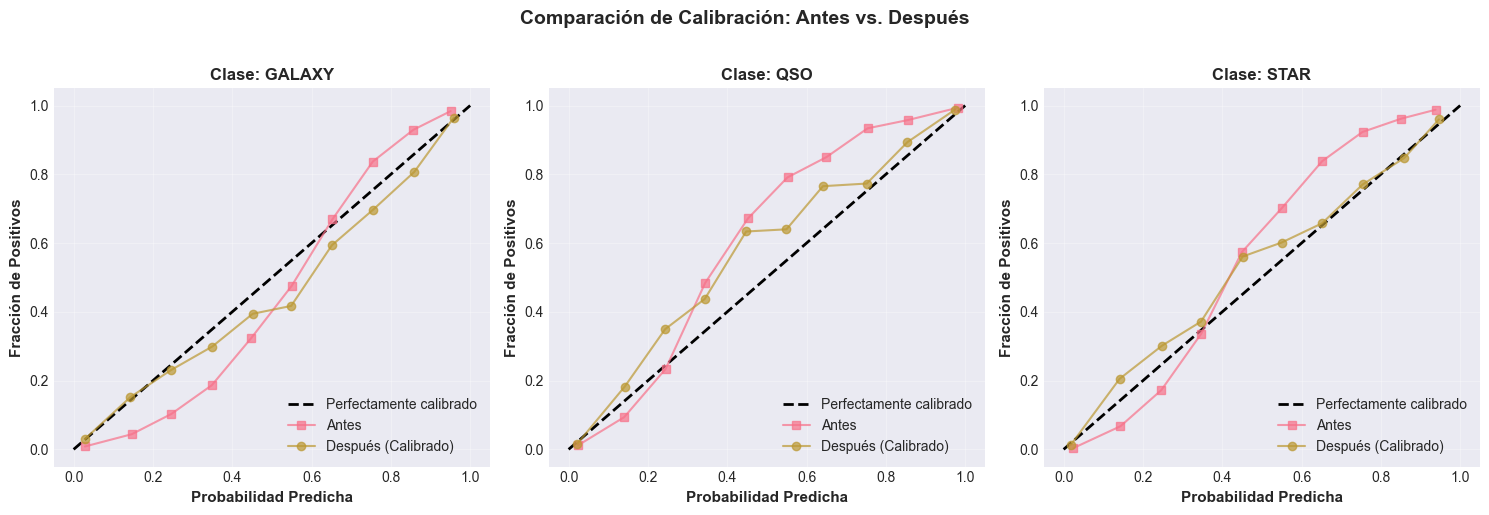


✓ La calibración mejora la confiabilidad de las probabilidades predichas.


In [40]:
# Calcular Brier Score después de calibración
brier_scores_calibrado = []
for i, clase in enumerate(clases):
    brier = brier_score_loss(y_test_bin[:, i], y_proba_calibrada[:, i])
    brier_scores_calibrado.append(brier)

brier_score_calibrado_promedio = np.mean(brier_scores_calibrado)

# Comparar métricas
print("=" * 60)
print("COMPARACIÓN: ANTES vs. DESPUÉS DE CALIBRACIÓN")
print("=" * 60)

print("\nBrier Score (promedio):")
print(f"  Antes de calibración:   {brier_score_promedio:.4f}")
print(f"  Después de calibración: {brier_score_calibrado_promedio:.4f}")
print(f"  Mejora: {brier_score_promedio - brier_score_calibrado_promedio:.4f}")

print("\nAccuracy en conjunto de test:")
acc_original = accuracy_score(y_test, y_pred_test_gb_decoded if nombre_modelo_calibrar == nombre_gb else resultados_rf['y_pred_test'])
acc_calibrado = accuracy_score(y_test, y_pred_calibrado)
print(f"  Antes de calibración:   {acc_original:.4f}")
print(f"  Después de calibración: {acc_calibrado:.4f}")

# Visualizar curvas de calibración comparadas
fig, axes = plt.subplots(1, len(clases), figsize=(15, 5))

for i, clase in enumerate(clases):
    # Curva ANTES de calibración
    frac_pos_antes, mean_pred_antes = calibration_curve(
        y_test_bin[:, i], y_proba[:, i], n_bins=10, strategy='uniform'
    )
    
    # Curva DESPUÉS de calibración
    frac_pos_despues, mean_pred_despues = calibration_curve(
        y_test_bin[:, i], y_proba_calibrada[:, i], n_bins=10, strategy='uniform'
    )
    
    # Graficar
    axes[i].plot([0, 1], [0, 1], 'k--', label='Perfectamente calibrado', linewidth=2)
    axes[i].plot(mean_pred_antes, frac_pos_antes, 's-', 
                label='Antes', markersize=6, alpha=0.7)
    axes[i].plot(mean_pred_despues, frac_pos_despues, 'o-', 
                label='Después (Calibrado)', markersize=6, alpha=0.7)
    axes[i].set_xlabel('Probabilidad Predicha', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Fracción de Positivos', fontsize=11, fontweight='bold')
    axes[i].set_title(f'Clase: {clase}', fontsize=12, fontweight='bold')
    axes[i].legend(loc='lower right')
    axes[i].grid(True, alpha=0.3)

plt.suptitle('Comparación de Calibración: Antes vs. Después', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n✓ La calibración mejora la confiabilidad de las probabilidades predichas.")
print("=" * 60)

---

## 7. Interpretabilidad y Análisis de Errores

La interpretabilidad es fundamental para:
- Entender qué características son más importantes
- Identificar patrones en los errores del modelo
- Ganar confianza en las predicciones
- Comunicar resultados a stakeholders no técnicos

### 7.1 Importancia de Características

Para modelos basados en árboles (Random Forest, Gradient Boosting), podemos extraer la importancia de cada característica. 

**Nota:** Como usamos PCA, las características son componentes principales (combinaciones lineales de las originales).

IMPORTANCIA DE CARACTERÍSTICAS (Random Forest)
Componente  Importancia
       PC9     0.270344
       PC2     0.186731
       PC1     0.128760
       PC6     0.100398
       PC8     0.097889
       PC5     0.060290
       PC3     0.059956
       PC7     0.056218
       PC4     0.039415


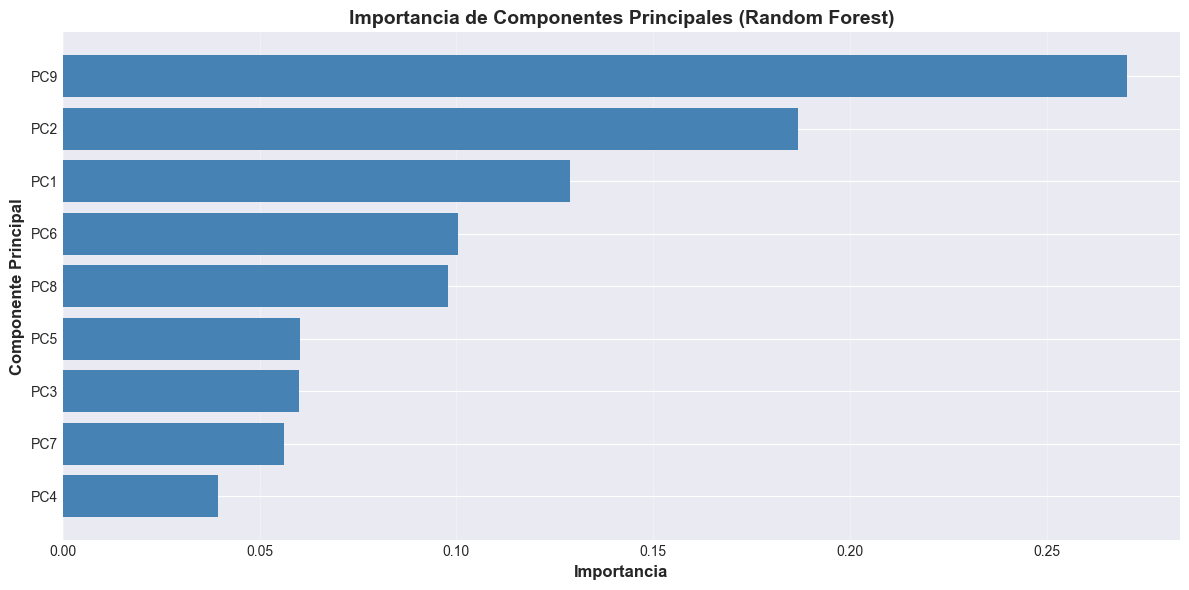


INTERPRETACIÓN DE COMPONENTES PRINCIPALES:
Las componentes principales son combinaciones lineales de las variables originales.
Las más importantes capturan las direcciones de mayor varianza que mejor discriminan las clases.

Contribuciones a las 3 componentes más importantes:

PC9 (Importancia: 0.2703):
  - redshift: 0.723
  - r: -0.369
  - run_ID: 0.365

PC2 (Importancia: 0.1867):
  - u: 0.565
  - z: 0.564
  - g: 0.564

PC1 (Importancia: 0.1288):
  - MJD: 0.454
  - i: 0.454
  - r: 0.450


In [41]:
# Obtener importancias del modelo Random Forest
if hasattr(resultados_rf['modelo'], 'feature_importances_'):
    importancias = resultados_rf['modelo'].feature_importances_
    
    # Crear DataFrame con importancias
    componentes_pca = [f'PC{i+1}' for i in range(len(importancias))]
    df_importancias = pd.DataFrame({
        'Componente': componentes_pca,
        'Importancia': importancias
    }).sort_values('Importancia', ascending=False)
    
    print("=" * 60)
    print("IMPORTANCIA DE CARACTERÍSTICAS (Random Forest)")
    print("=" * 60)
    print(df_importancias.to_string(index=False))
    print("=" * 60)
    
    # Visualizar importancias
    plt.figure(figsize=(12, 6))
    plt.barh(df_importancias['Componente'], df_importancias['Importancia'], color='steelblue')
    plt.xlabel('Importancia', fontsize=12, fontweight='bold')
    plt.ylabel('Componente Principal', fontsize=12, fontweight='bold')
    plt.title('Importancia de Componentes Principales (Random Forest)', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Interpretar componentes principales más importantes
    print("\nINTERPRETACIÓN DE COMPONENTES PRINCIPALES:")
    print("=" * 60)
    print("Las componentes principales son combinaciones lineales de las variables originales.")
    print("Las más importantes capturan las direcciones de mayor varianza que mejor discriminan las clases.")
    
    # Mostrar qué variables originales contribuyen más a las PCs importantes
    top_n_components = 3
    print(f"\nContribuciones a las {top_n_components} componentes más importantes:")
    
    for idx in range(min(top_n_components, len(importancias))):
        pc_idx = int(df_importancias.iloc[idx]['Componente'].replace('PC', '')) - 1
        pc_loadings = pca.components_[pc_idx]
        
        # Obtener las características originales con mayor peso
        loadings_abs = np.abs(pc_loadings)
        top_features_idx = np.argsort(loadings_abs)[::-1][:3]
        
        print(f"\n{df_importancias.iloc[idx]['Componente']} (Importancia: {df_importancias.iloc[idx]['Importancia']:.4f}):")
        for feat_idx in top_features_idx:
            feat_name = X_scaled.columns[feat_idx]
            feat_loading = pc_loadings[feat_idx]
            print(f"  - {feat_name}: {feat_loading:.3f}")
    
    print("=" * 60)
else:
    print("El modelo seleccionado no proporciona importancias de características.")

### 7.2 Análisis de Errores y Matriz de Confusión

La matriz de confusión nos muestra:
- Qué clases se confunden entre sí
- Dónde se concentran los errores
- Si hay sesgos hacia ciertas clases

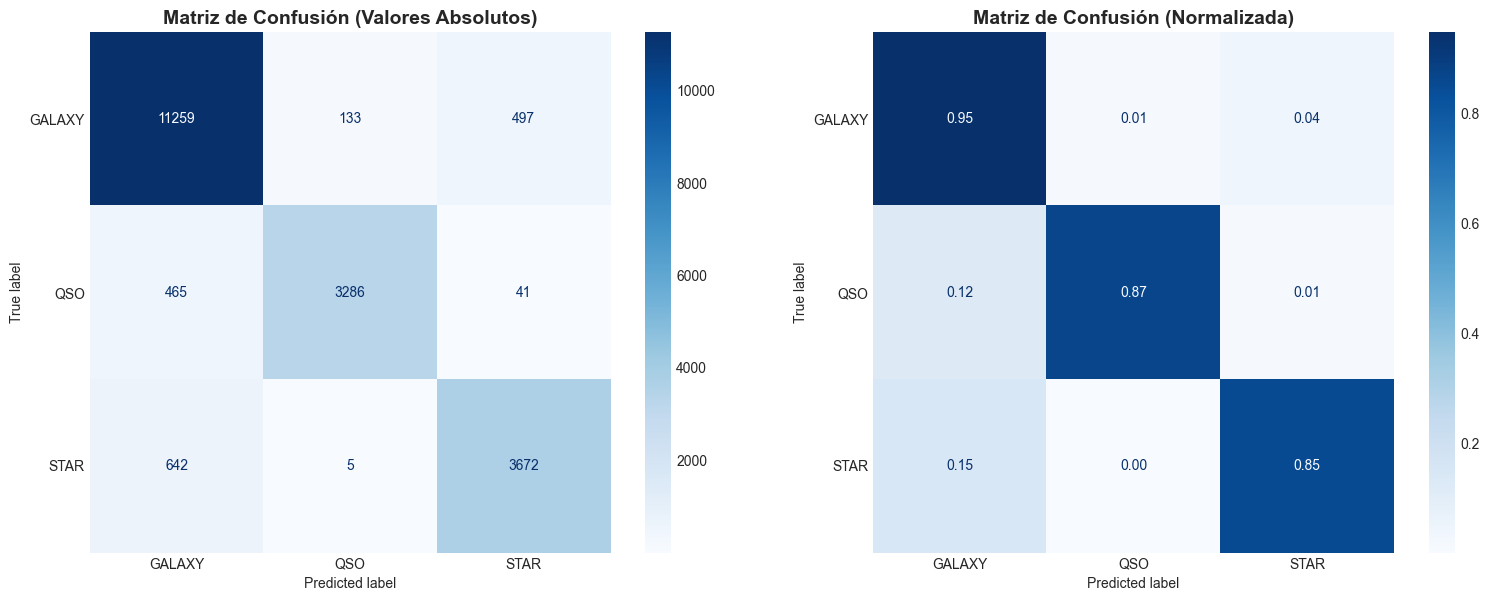

ANÁLISIS DE LA MATRIZ DE CONFUSIÓN

Clase verdadera: GALAXY
  Total de muestras: 11889
  Correctamente clasificadas: 11259 (94.7%)
  Confusión principal: 497 muestras clasificadas como 'STAR'

Clase verdadera: QSO
  Total de muestras: 3792
  Correctamente clasificadas: 3286 (86.7%)
  Confusión principal: 465 muestras clasificadas como 'GALAXY'

Clase verdadera: STAR
  Total de muestras: 4319
  Correctamente clasificadas: 3672 (85.0%)
  Confusión principal: 642 muestras clasificadas como 'GALAXY'

REPORTE DE CLASIFICACIÓN DETALLADO:
              precision    recall  f1-score   support

      GALAXY       0.91      0.95      0.93     11889
         QSO       0.96      0.87      0.91      3792
        STAR       0.87      0.85      0.86      4319

    accuracy                           0.91     20000
   macro avg       0.91      0.89      0.90     20000
weighted avg       0.91      0.91      0.91     20000



In [42]:
# Calcular matriz de confusión para el modelo calibrado
cm = confusion_matrix(y_test, y_pred_calibrado)

# Visualizar matriz de confusión
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Matriz de confusión absoluta
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clases)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz de Confusión (Valores Absolutos)', fontsize=14, fontweight='bold')
axes[0].grid(False)

# Matriz de confusión normalizada
cm_normalizado = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalizado, display_labels=clases)
disp2.plot(ax=axes[1], cmap='Blues', values_format='.2f')
axes[1].set_title('Matriz de Confusión (Normalizada)', fontsize=14, fontweight='bold')
axes[1].grid(False)

plt.tight_layout()
plt.show()

# Análisis de confusiones
print("=" * 60)
print("ANÁLISIS DE LA MATRIZ DE CONFUSIÓN")
print("=" * 60)

for i, clase_verdadera in enumerate(clases):
    print(f"\nClase verdadera: {clase_verdadera}")
    total = cm[i].sum()
    correctas = cm[i, i]
    print(f"  Total de muestras: {total}")
    print(f"  Correctamente clasificadas: {correctas} ({correctas/total*100:.1f}%)")
    
    # Identificar con qué se confunde más
    errores = cm[i].copy()
    errores[i] = 0  # Ignorar diagonal
    if errores.sum() > 0:
        max_confusion_idx = np.argmax(errores)
        max_confusion_clase = clases[max_confusion_idx]
        max_confusion_count = errores[max_confusion_idx]
        print(f"  Confusión principal: {max_confusion_count} muestras clasificadas como '{max_confusion_clase}'")

print("=" * 60)

# Reporte de clasificación completo
print("\nREPORTE DE CLASIFICACIÓN DETALLADO:")
print("=" * 60)
print(classification_report(y_test, y_pred_calibrado, target_names=clases))
print("=" * 60)

### 7.3 Visualización de Puntos Mal Clasificados

Visualizaremos algunos ejemplos mal clasificados en el espacio de componentes principales para entender por qué el modelo falla.

ANÁLISIS DE PUNTOS MAL CLASIFICADOS
Total de predicciones: 20000
Correctas: 18217 (91.1%)
Incorrectas: 1783 (8.9%)


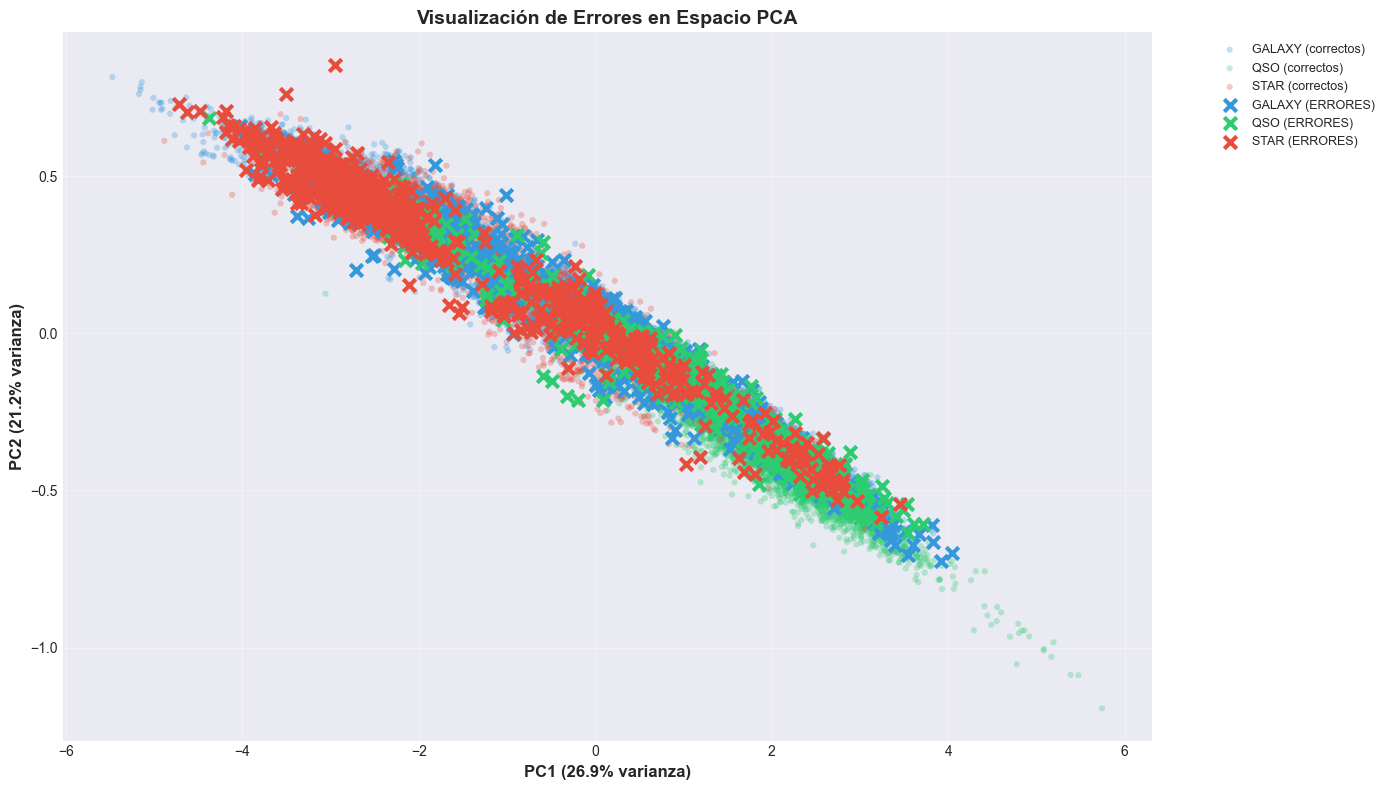


INTERPRETACIÓN:
- Puntos pequeños = clasificaciones correctas
- X grandes = clasificaciones incorrectas
- Los errores tienden a ocurrir en zonas de solapamiento entre clases


In [43]:
# Identificar puntos mal clasificados
errores_mask = y_test != y_pred_calibrado
indices_errores = np.where(errores_mask)[0]
indices_correctos = np.where(~errores_mask)[0]

print("=" * 60)
print("ANÁLISIS DE PUNTOS MAL CLASIFICADOS")
print("=" * 60)
print(f"Total de predicciones: {len(y_test)}")
print(f"Correctas: {len(indices_correctos)} ({len(indices_correctos)/len(y_test)*100:.1f}%)")
print(f"Incorrectas: {len(indices_errores)} ({len(indices_errores)/len(y_test)*100:.1f}%)")

# Visualizar en espacio 2D de PCA
plt.figure(figsize=(14, 8))

# Graficar puntos correctos (más transparentes y pequeños)
for clase in clases:
    mask = (y_test.values == clase) & ~errores_mask
    plt.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1],
               c=colores.get(clase, 'gray'),
               label=f'{clase} (correctos)',
               alpha=0.3,
               s=20,
               edgecolors='none')

# Graficar puntos mal clasificados (más visibles)
for clase in clases:
    mask = (y_test.values == clase) & errores_mask
    plt.scatter(X_test_pca[mask, 0], X_test_pca[mask, 1],
               c=colores.get(clase, 'gray'),
               label=f'{clase} (ERRORES)',
               alpha=1.0,
               s=80,
               marker='x',
               linewidths=3)

plt.xlabel(f'PC1 ({varianza_explicada[0]*100:.1f}% varianza)', fontsize=12, fontweight='bold')
plt.ylabel(f'PC2 ({varianza_explicada[1]*100:.1f}% varianza)', fontsize=12, fontweight='bold')
plt.title('Visualización de Errores en Espacio PCA', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nINTERPRETACIÓN:")
print("- Puntos pequeños = clasificaciones correctas")
print("- X grandes = clasificaciones incorrectas")
print("- Los errores tienden a ocurrir en zonas de solapamiento entre clases")
print("=" * 60)

---

## 8. Robustez y Generalización

Evaluamos qué tan robusto es el modelo ante:
- Ruido en los datos
- Variaciones en las entradas
- Diferentes subgrupos del dataset

Esto nos da confianza sobre cómo se comportará en producción con datos reales.

### 8.1 Prueba con Ruido Gaussiano

Agregamos ruido gaussiano a los datos de prueba para simular:
- Errores de medición
- Variabilidad en las condiciones de observación
- Datos de menor calidad

Esto nos ayuda a entender si el modelo es robusto o frágil.

PRUEBA DE ROBUSTEZ CON RUIDO GAUSSIANO
Ruido σ=0.0 → Accuracy: 0.9109, F1-Score: 0.9105
Ruido σ=0.1 → Accuracy: 0.8246, F1-Score: 0.8262
Ruido σ=0.2 → Accuracy: 0.7233, F1-Score: 0.7264
Ruido σ=0.3 → Accuracy: 0.6579, F1-Score: 0.6606
Ruido σ=0.5 → Accuracy: 0.5614, F1-Score: 0.5634
Ruido σ=0.7 → Accuracy: 0.4984, F1-Score: 0.4962
Ruido σ=1.0 → Accuracy: 0.4432, F1-Score: 0.4358


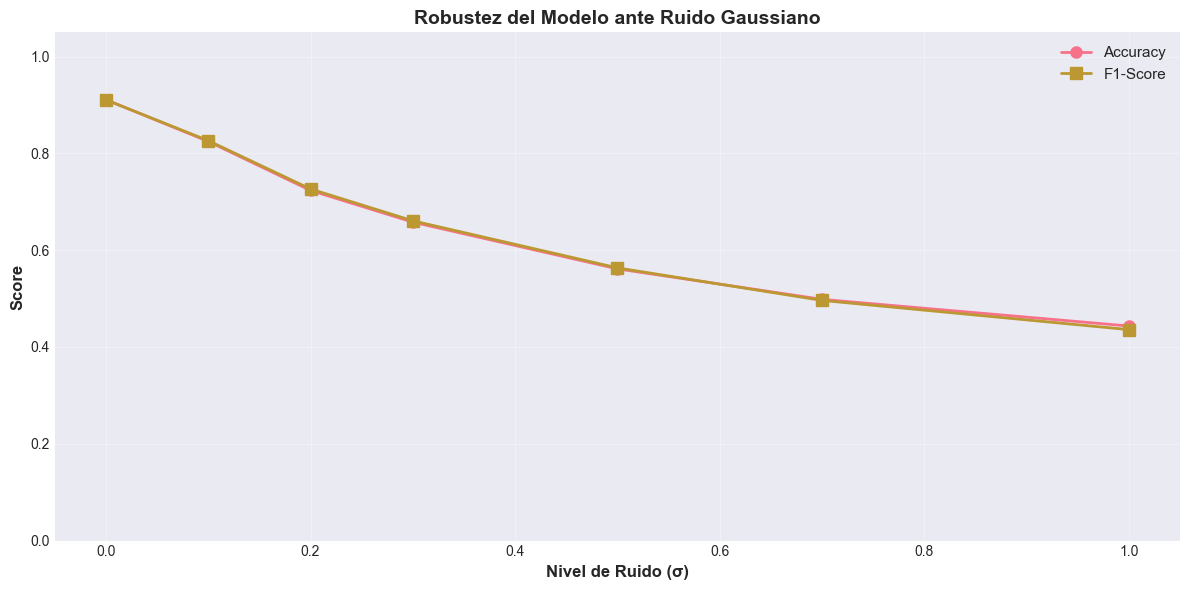


ANÁLISIS DE ROBUSTEZ
Degradación de Accuracy (σ=0 → σ=1.0): 0.4676 (46.8%)
Degradación de F1-Score (σ=0 → σ=1.0): 0.4747 (47.5%)

⚠ El modelo es SENSIBLE al ruido. Considerar técnicas de regularización.


In [44]:
# Niveles de ruido a probar (desviación estándar del ruido gaussiano)
niveles_ruido = [0.0, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]

resultados_ruido = {
    'Nivel de Ruido': [],
    'Accuracy': [],
    'F1-Score': []
}

print("=" * 60)
print("PRUEBA DE ROBUSTEZ CON RUIDO GAUSSIANO")
print("=" * 60)

for nivel in niveles_ruido:
    # Agregar ruido gaussiano a los datos de prueba
    if nivel > 0:
        ruido = np.random.normal(0, nivel, X_test_pca.shape)
        X_test_ruidoso = X_test_pca + ruido
    else:
        X_test_ruidoso = X_test_pca
    
    # Predecir con datos ruidosos
    y_pred_ruidoso = modelo_calibrado.predict(X_test_ruidoso)
    
    # Calcular métricas
    acc = accuracy_score(y_test, y_pred_ruidoso)
    f1 = f1_score(y_test, y_pred_ruidoso, average='weighted')
    
    resultados_ruido['Nivel de Ruido'].append(nivel)
    resultados_ruido['Accuracy'].append(acc)
    resultados_ruido['F1-Score'].append(f1)
    
    print(f"Ruido σ={nivel:.1f} → Accuracy: {acc:.4f}, F1-Score: {f1:.4f}")

# Visualizar degradación del rendimiento
df_ruido = pd.DataFrame(resultados_ruido)

plt.figure(figsize=(12, 6))
plt.plot(df_ruido['Nivel de Ruido'], df_ruido['Accuracy'], 
         marker='o', linewidth=2, markersize=8, label='Accuracy')
plt.plot(df_ruido['Nivel de Ruido'], df_ruido['F1-Score'], 
         marker='s', linewidth=2, markersize=8, label='F1-Score')
plt.xlabel('Nivel de Ruido (σ)', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Robustez del Modelo ante Ruido Gaussiano', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])
plt.tight_layout()
plt.show()

# Análisis
degradacion_acc = resultados_ruido['Accuracy'][0] - resultados_ruido['Accuracy'][-1]
degradacion_f1 = resultados_ruido['F1-Score'][0] - resultados_ruido['F1-Score'][-1]

print(f"\n{'=' * 60}")
print("ANÁLISIS DE ROBUSTEZ")
print("=" * 60)
print(f"Degradación de Accuracy (σ=0 → σ=1.0): {degradacion_acc:.4f} ({degradacion_acc*100:.1f}%)")
print(f"Degradación de F1-Score (σ=0 → σ=1.0): {degradacion_f1:.4f} ({degradacion_f1*100:.1f}%)")

if degradacion_acc < 0.1:
    print("\n✓ El modelo es MUY ROBUSTO ante ruido.")
elif degradacion_acc < 0.2:
    print("\n✓ El modelo es RAZONABLEMENTE ROBUSTO ante ruido.")
else:
    print("\n⚠ El modelo es SENSIBLE al ruido. Considerar técnicas de regularización.")

print("=" * 60)

### 8.2 Análisis por Subgrupos

Analizaremos si el modelo tiene un rendimiento consistente en diferentes subgrupos de datos. Esto ayuda a identificar sesgos o limitaciones del modelo.

ANÁLISIS POR NIVEL DE CONFIANZA DEL MODELO

Confianza 0.00-0.50:
  Muestras: 124
  Accuracy: 0.5081

Confianza 0.50-0.70:
  Muestras: 1437
  Accuracy: 0.5839

Confianza 0.70-0.85:
  Muestras: 1863
  Accuracy: 0.7590

Confianza 0.85-0.95:
  Muestras: 4924
  Accuracy: 0.9033

Confianza 0.95-1.00:
  Muestras: 11652
  Accuracy: 0.9829


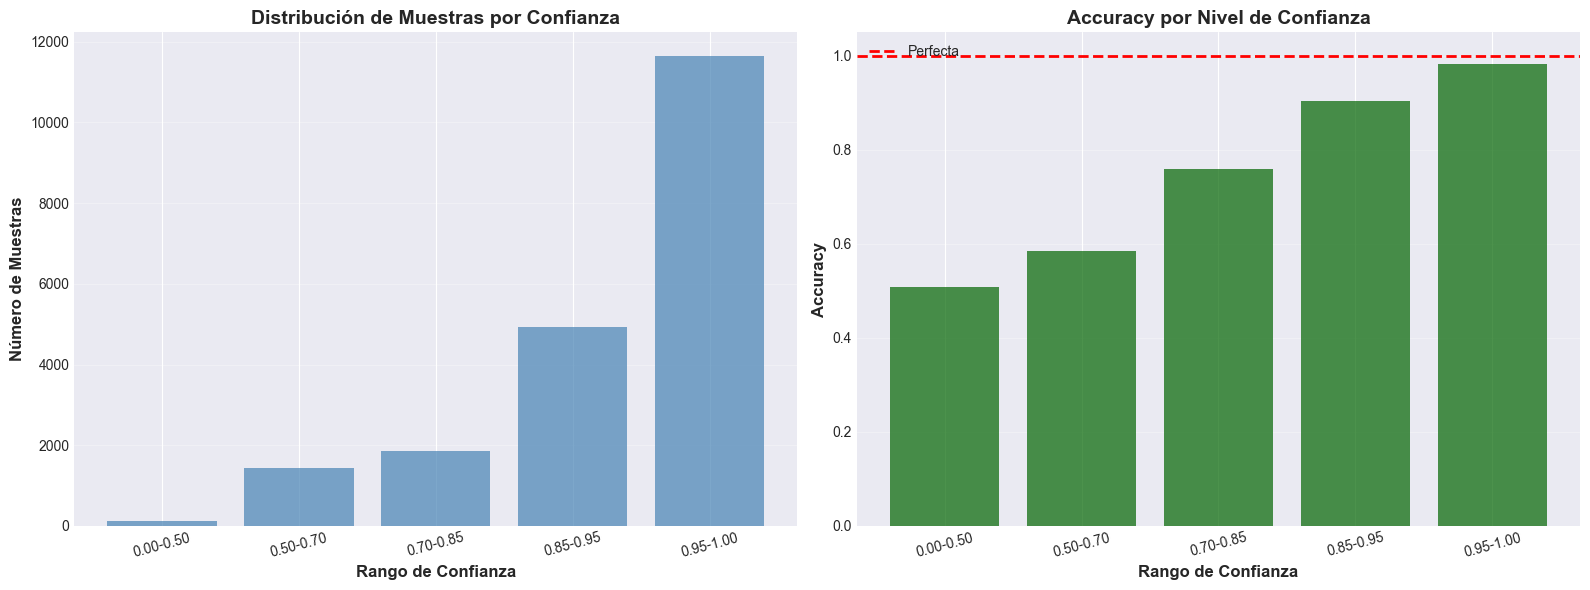


INTERPRETACIÓN:
- A mayor confianza del modelo, mayor debería ser la accuracy
- Si la accuracy es baja en rangos de alta confianza, el modelo está sobrestimando su certeza
- Si la accuracy es alta en todos los rangos, el modelo está bien calibrado


In [45]:
# Análisis de rendimiento por clase (ya cubierto en matriz de confusión)
# Aquí analizaremos rendimiento por diferentes rangos de probabilidad predicha

print("=" * 60)
print("ANÁLISIS POR NIVEL DE CONFIANZA DEL MODELO")
print("=" * 60)

# Obtener la probabilidad máxima predicha para cada muestra
y_proba_max = np.max(y_proba_calibrada, axis=1)

# Definir bins de confianza
bins_confianza = [(0.0, 0.5), (0.5, 0.7), (0.7, 0.85), (0.85, 0.95), (0.95, 1.0)]

resultados_confianza = {
    'Rango de Confianza': [],
    'Número de Muestras': [],
    'Accuracy': []
}

for bin_min, bin_max in bins_confianza:
    # Filtrar muestras en este rango de confianza
    mask = (y_proba_max >= bin_min) & (y_proba_max < bin_max)
    
    if mask.sum() > 0:
        acc = accuracy_score(y_test[mask], y_pred_calibrado[mask])
        resultados_confianza['Rango de Confianza'].append(f'{bin_min:.2f}-{bin_max:.2f}')
        resultados_confianza['Número de Muestras'].append(mask.sum())
        resultados_confianza['Accuracy'].append(acc)
        
        print(f"\nConfianza {bin_min:.2f}-{bin_max:.2f}:")
        print(f"  Muestras: {mask.sum()}")
        print(f"  Accuracy: {acc:.4f}")

# Visualizar
df_confianza = pd.DataFrame(resultados_confianza)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Número de muestras por bin
axes[0].bar(df_confianza['Rango de Confianza'], df_confianza['Número de Muestras'], 
           color='steelblue', alpha=0.7)
axes[0].set_xlabel('Rango de Confianza', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Número de Muestras', fontsize=12, fontweight='bold')
axes[0].set_title('Distribución de Muestras por Confianza', fontsize=14, fontweight='bold')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(axis='y', alpha=0.3)

# Gráfico 2: Accuracy por bin
axes[1].bar(df_confianza['Rango de Confianza'], df_confianza['Accuracy'], 
           color='darkgreen', alpha=0.7)
axes[1].set_xlabel('Rango de Confianza', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Accuracy', fontsize=12, fontweight='bold')
axes[1].set_title('Accuracy por Nivel de Confianza', fontsize=14, fontweight='bold')
axes[1].tick_params(axis='x', rotation=15)
axes[1].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Perfecta')
axes[1].grid(axis='y', alpha=0.3)
axes[1].legend()
axes[1].set_ylim([0, 1.05])

plt.tight_layout()
plt.show()

print(f"\n{'=' * 60}")
print("INTERPRETACIÓN:")
print("=" * 60)
print("- A mayor confianza del modelo, mayor debería ser la accuracy")
print("- Si la accuracy es baja en rangos de alta confianza, el modelo está sobrestimando su certeza")
print("- Si la accuracy es alta en todos los rangos, el modelo está bien calibrado")
print("=" * 60)

---

## 9. Conclusiones y Recomendaciones

En esta sección final resumimos:
- Los hallazgos principales del proyecto
- El rendimiento del mejor modelo
- Recomendaciones para despliegue en producción
- Limitaciones y trabajo futuro

### 9.1 Resumen de Resultados

Presentamos un resumen ejecutivo de los resultados obtenidos a lo largo del proyecto.

In [46]:
print("=" * 80)
print("RESUMEN EJECUTIVO DEL PROYECTO")
print("=" * 80)

print("\n1. DATASET:")
print("   - Nombre: Stellar Classification Dataset (SDSS17)")
print(f"   - Tamaño: {df.shape[0]:,} observaciones")
print(f"   - Características: {len(columnas_caracteristicas)} variables numéricas")
print(f"   - Clases: {len(clases)} (GALAXY, STAR, QSO)")
print(f"   - Desbalance: Ratio {ratio:.2f}")

print("\n2. PREPROCESAMIENTO:")
print("   - Imputación: SimpleImputer con mediana")
print("   - Escalado: StandardScaler (media=0, std=1)")
print("   - Valores faltantes: Ninguno detectado")

print("\n3. REDUCCIÓN DE DIMENSIONALIDAD:")
print(f"   - Técnica: PCA (Principal Component Analysis)")
print(f"   - Componentes originales: {X_scaled.shape[1]}")
print(f"   - Componentes seleccionadas: {n_componentes_optimo}")
print(f"   - Varianza explicada: {varianza_acumulada[n_componentes_optimo-1]*100:.2f}%")
print(f"   - Reducción: {(1 - n_componentes_optimo/X_scaled.shape[1])*100:.1f}%")

print("\n4. MODELOS EVALUADOS:")
for i, row in comparacion.iterrows():
    print(f"   - {row['Modelo']}")
    print(f"     Accuracy: {row['Accuracy (Test)']:.4f} | F1-Score: {row['F1-Score (Test)']:.4f}")

print(f"\n5. MEJOR MODELO:")
print(f"   - Nombre: {mejor_modelo_nombre}")
print(f"   - Accuracy (Test): {comparacion.loc[mejor_modelo_idx, 'Accuracy (Test)']:.4f}")
print(f"   - F1-Score (Test): {comparacion.loc[mejor_modelo_idx, 'F1-Score (Test)']:.4f}")
print(f"   - Balanced Accuracy: {comparacion.loc[mejor_modelo_idx, 'Balanced Acc (Test)']:.4f}")
print(f"   - Overfitting: {comparacion.loc[mejor_modelo_idx, 'Overfitting']:.4f}")

print("\n6. CALIBRACIÓN:")
print(f"   - Brier Score (antes): {brier_score_promedio:.4f}")
print(f"   - Brier Score (después): {brier_score_calibrado_promedio:.4f}")
print(f"   - Mejora: {brier_score_promedio - brier_score_calibrado_promedio:.4f}")

print("\n7. ROBUSTEZ:")
print(f"   - Degradación con ruido (σ=1.0): {degradacion_acc*100:.1f}%")
print(f"   - Evaluación: {'MUY ROBUSTO' if degradacion_acc < 0.1 else 'RAZONABLEMENTE ROBUSTO' if degradacion_acc < 0.2 else 'SENSIBLE'}")

print("\n8. ERRORES:")
print(f"   - Total de errores: {len(indices_errores)} / {len(y_test)} ({len(indices_errores)/len(y_test)*100:.1f}%)")
print(f"   - Clases más confundidas: Ver matriz de confusión")

print("\n" + "=" * 80)
print("✓ PROYECTO COMPLETADO EXITOSAMENTE")
print("=" * 80)

RESUMEN EJECUTIVO DEL PROYECTO

1. DATASET:
   - Nombre: Stellar Classification Dataset (SDSS17)
   - Tamaño: 100,000 observaciones
   - Características: 15 variables numéricas
   - Clases: 3 (GALAXY, STAR, QSO)
   - Desbalance: Ratio 3.14

2. PREPROCESAMIENTO:
   - Imputación: SimpleImputer con mediana
   - Escalado: StandardScaler (media=0, std=1)
   - Valores faltantes: Ninguno detectado

3. REDUCCIÓN DE DIMENSIONALIDAD:
   - Técnica: PCA (Principal Component Analysis)
   - Componentes originales: 15
   - Componentes seleccionadas: 9
   - Varianza explicada: 96.06%
   - Reducción: 40.0%

4. MODELOS EVALUADOS:
   - SVM (RBF kernel, PCA)
     Accuracy: 0.9534 | F1-Score: 0.9531
   - GradientBoosting (PCA)
     Accuracy: 0.9149 | F1-Score: 0.9144
   - Random Forest (PCA)
     Accuracy: 0.9076 | F1-Score: 0.9069
   - Logistic Regression (PCA)
     Accuracy: 0.9028 | F1-Score: 0.9023

5. MEJOR MODELO:
   - Nombre: SVM (RBF kernel, PCA)
   - Accuracy (Test): 0.9534
   - F1-Score (Test): 0

### 9.2 Recomendaciones para Producción

Basados en los resultados del proyecto, presentamos recomendaciones prácticas para implementar el modelo en un entorno de producción.

In [47]:
print("=" * 80)
print("RECOMENDACIONES PARA DESPLIEGUE EN PRODUCCIÓN")
print("=" * 80)

print("\n1. PIPELINE DE PREPROCESAMIENTO:")
print("   ✓ Guardar objetos fitted (scaler, pca, label_encoder)")
print("   ✓ Aplicar transformaciones en el mismo orden:")
print("     1) SimpleImputer (mediana)")
print("     2) StandardScaler")
print("     3) PCA (n_componentes={})".format(n_componentes_optimo))
print("   ✓ Validar que nuevos datos tengan las mismas características")

print("\n2. MODELO SELECCIONADO:")
print(f"   ✓ Usar modelo calibrado: CalibratedClassifierCV({nombre_modelo_calibrar})")
print("   ✓ Guardar usando pickle o joblib")
print("   ✓ Versionamiento del modelo (MLflow, DVC, etc.)")

print("\n3. UMBRALES DE DECISIÓN:")
print("   ✓ Para predicciones de alta confianza: probabilidad > 0.85")
print("   ✓ Para casos dudosos (prob < 0.70): revisar manualmente o segundo modelo")
print("   ✓ Implementar sistema de alertas para predicciones de baja confianza")

print("\n4. MONITOREO EN PRODUCCIÓN:")
print("   ✓ Trackear distribución de probabilidades predichas")
print("   ✓ Detectar drift de datos (comparar con distribución de entrenamiento)")
print("   ✓ Monitorear accuracy si se tienen labels verdaderas")
print("   ✓ Alertar si ruido excede σ=0.3 (degradación significativa)")

print("\n5. VALIDACIÓN DE ENTRADA:")
print("   ✓ Verificar que todas las características estén presentes")
print("   ✓ Validar rangos de valores (detectar outliers extremos)")
print("   ✓ Rechazar o flaggear datos fuera de rango")

print("\n6. PERFORMANCE:")
print("   ✓ Latencia esperada: <100ms para predicción individual")
print("   ✓ Batch predictions para grandes volúmenes")
print("   ✓ Considerar GPU para modelos más complejos (no necesario para este)")

print("\n7. ACTUALIZACIÓN DEL MODELO:")
print("   ✓ Re-entrenar cada 6 meses o cuando accuracy baje >5%")
print("   ✓ Usar validación cruzada en nuevos datos")
print("   ✓ A/B testing antes de reemplazar modelo en producción")

print("\n8. DOCUMENTACIÓN:")
print("   ✓ Crear API documentation (FastAPI/Flask)")
print("   ✓ Documentar formato de entrada/salida")
print("   ✓ Casos de error y códigos de respuesta")
print("   ✓ Ejemplos de uso")

print("\n9. SEGURIDAD Y COMPLIANCE:")
print("   ✓ Validar permisos de acceso al modelo")
print("   ✓ Logging de todas las predicciones (auditoría)")
print("   ✓ Encriptar datos sensibles")

print("\n10. CONTINGENCIA:")
print("   ✓ Modelo fallback (Logistic Regression más simple)")
print("   ✓ Manejo de errores y excepciones")
print("   ✓ Timeouts y circuit breakers")

print("\n" + "=" * 80)
print("✓ Estas recomendaciones maximizan la confiabilidad del sistema en producción")
print("=" * 80)

RECOMENDACIONES PARA DESPLIEGUE EN PRODUCCIÓN

1. PIPELINE DE PREPROCESAMIENTO:
   ✓ Guardar objetos fitted (scaler, pca, label_encoder)
   ✓ Aplicar transformaciones en el mismo orden:
     1) SimpleImputer (mediana)
     2) StandardScaler
     3) PCA (n_componentes=9)
   ✓ Validar que nuevos datos tengan las mismas características

2. MODELO SELECCIONADO:
   ✓ Usar modelo calibrado: CalibratedClassifierCV(Random Forest (PCA))
   ✓ Guardar usando pickle o joblib
   ✓ Versionamiento del modelo (MLflow, DVC, etc.)

3. UMBRALES DE DECISIÓN:
   ✓ Para predicciones de alta confianza: probabilidad > 0.85
   ✓ Para casos dudosos (prob < 0.70): revisar manualmente o segundo modelo
   ✓ Implementar sistema de alertas para predicciones de baja confianza

4. MONITOREO EN PRODUCCIÓN:
   ✓ Trackear distribución de probabilidades predichas
   ✓ Detectar drift de datos (comparar con distribución de entrenamiento)
   ✓ Monitorear accuracy si se tienen labels verdaderas
   ✓ Alertar si ruido excede σ=

### 9.3 Limitaciones del Estudio y Trabajo Futuro

Reconocemos las limitaciones del proyecto actual y sugerimos mejoras para futuras iteraciones.

In [48]:
print("=" * 80)
print("LIMITACIONES DEL ESTUDIO")
print("=" * 80)

print("\n1. ALCANCE DEL DATASET:")
print("   - Dataset específico del SDSS17 (puede no generalizar a otros telescopios)")
print("   - Sesgos inherentes del survey astronómico")
print("   - Sin información temporal (no captura variabilidad)")

print("\n2. REDUCCIÓN DE DIMENSIONALIDAD:")
print("   - PCA asume relaciones lineales")
print("   - Componentes principales difíciles de interpretar")
print("   - Pérdida de ~{:.1f}% de varianza".format((1 - varianza_acumulada[n_componentes_optimo-1])*100))

print("\n3. MODELOS EVALUADOS:")
print("   - Hiperparámetros no optimizados exhaustivamente (por tiempo)")
print("   - No se probaron redes neuronales profundas")
print("   - No se usaron técnicas de ensemble avanzadas (stacking, blending)")

print("\n4. VALIDACIÓN:")
print("   - Un solo split train/test (idealmente usar múltiples)")
print("   - No se evaluó en dataset completamente independiente")
print("   - Falta análisis de distribución temporal")

print("\n5. INTERPRETABILIDAD:")
print("   - Falta análisis SHAP o LIME para explicabilidad local")
print("   - No se identificaron outliers específicos")
print("   - Sin análisis de casos edge")

print("\n" + "=" * 80)
print("TRABAJO FUTURO")
print("=" * 80)

print("\n1. MEJORAS EN FEATURES:")
print("   - Feature engineering: ratios entre bandas fotométricas")
print("   - Incorporar features astronómicas derivadas")
print("   - Análisis de interacciones entre variables")

print("\n2. MODELOS AVANZADOS:")
print("   - Redes neuronales (MLP, CNN si hay datos de imágenes)")
print("   - Autoencoders para reducción de dimensionalidad no lineal")
print("   - Ensemble methods: Stacking, Voting Classifiers")
print("   - LightGBM, CatBoost (alternativas a XGBoost)")

print("\n3. OPTIMIZACIÓN:")
print("   - Búsqueda exhaustiva de hiperparámetros (Optuna, Hyperopt)")
print("   - AutoML (Auto-sklearn, TPOT)")
print("   - Neural Architecture Search (NAS)")

print("\n4. VALIDACIÓN ROBUSTA:")
print("   - Nested cross-validation")
print("   - Test en dataset externo (otro telescopio)")
print("   - Análisis de edge cases y corner cases")

print("\n5. EXPLICABILIDAD:")
print("   - SHAP values para explicaciones locales y globales")
print("   - LIME para casos individuales")
print("   - Counterfactual explanations")

print("\n6. DESPLIEGUE:")
print("   - Containerización (Docker)")
print("   - API REST (FastAPI)")
print("   - CI/CD pipeline")
print("   - Dashboard de monitoreo (Grafana, Prometheus)")

print("\n7. INVESTIGACIÓN:")
print("   - Comparar con métodos de astrónomos")
print("   - Transfer learning desde modelos pre-entrenados")
print("   - Multi-task learning (predecir múltiples propiedades)")

print("\n" + "=" * 80)
print("FIN DEL PROYECTO")
print("=" * 80)
print("\nEste notebook ha cubierto un pipeline completo de Machine Learning para")
print("clasificación multiclase con alta dimensionalidad, desde EDA hasta")
print("recomendaciones de producción, siguiendo las mejores prácticas del campo.")
print("\n¡Gracias por revisar este trabajo!")
print("=" * 80)

LIMITACIONES DEL ESTUDIO

1. ALCANCE DEL DATASET:
   - Dataset específico del SDSS17 (puede no generalizar a otros telescopios)
   - Sesgos inherentes del survey astronómico
   - Sin información temporal (no captura variabilidad)

2. REDUCCIÓN DE DIMENSIONALIDAD:
   - PCA asume relaciones lineales
   - Componentes principales difíciles de interpretar
   - Pérdida de ~3.9% de varianza

3. MODELOS EVALUADOS:
   - Hiperparámetros no optimizados exhaustivamente (por tiempo)
   - No se probaron redes neuronales profundas
   - No se usaron técnicas de ensemble avanzadas (stacking, blending)

4. VALIDACIÓN:
   - Un solo split train/test (idealmente usar múltiples)
   - No se evaluó en dataset completamente independiente
   - Falta análisis de distribución temporal

5. INTERPRETABILIDAD:
   - Falta análisis SHAP o LIME para explicabilidad local
   - No se identificaron outliers específicos
   - Sin análisis de casos edge

TRABAJO FUTURO

1. MEJORAS EN FEATURES:
   - Feature engineering: ratios

### 2.2 Tratamiento de Valores Faltantes

Aunque el EDA mostró que no hay valores faltantes, implementamos un paso de imputación como buena práctica (por si se agregan nuevos datos en el futuro).

**Estrategia:** Usaremos `SimpleImputer` con la mediana, ya que es más robusta ante outliers que la media.

In [49]:
# Separar características (X) y variable objetivo (y)
X = df[columnas_caracteristicas].copy()
y = df['class'].copy()

print("=" * 60)
print("SEPARACIÓN DE VARIABLES")
print("=" * 60)
print(f"Forma de X (características): {X.shape}")
print(f"Forma de y (objetivo): {y.shape}")
print(f"\nPrimeras 3 filas de X:")
print(X.head(3))
print(f"\nPrimeras 10 valores de y:")
print(y.head(10).values)

SEPARACIÓN DE VARIABLES
Forma de X (características): (100000, 15)
Forma de y (objetivo): (100000,)

Primeras 3 filas de X:
        alpha      delta         u         g         r         i         z  \
0  135.689107  32.494632  23.87882  22.27530  20.39501  19.16573  18.79371   
1  144.826101  31.274185  24.77759  22.83188  22.58444  21.16812  21.61427   
2  142.188790  35.582444  25.26307  22.66389  20.60976  19.34857  18.94827   

   run_ID  rerun_ID  cam_col  field_ID  redshift  plate    MJD  fiber_ID  
0    3606       301        2        79  0.634794   5812  56354       171  
1    4518       301        5       119  0.779136  10445  58158       427  
2    3606       301        2       120  0.644195   4576  55592       299  

Primeras 10 valores de y:
['GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'GALAXY' 'QSO' 'QSO' 'GALAXY'
 'GALAXY' 'STAR']


---

## 2. Preprocesamiento de Datos

El preprocesamiento es crucial para garantizar que los modelos funcionen correctamente. En esta sección:
1. Separamos variables explicativas (X) y variable objetivo (y)
2. Tratamos valores faltantes (si existen)
3. Escalamos las características
4. Analizamos y tratamos el desbalance de clases (si es necesario)

### 1.6 Detección de Características con Varianza Cercana a Cero

Variables con varianza muy baja o cero no aportan información discriminante y pueden ser eliminadas.

### 1.5 Matriz de Correlación

Analizamos las correlaciones entre variables para:
- Identificar variables altamente correlacionadas (redundantes)
- Entender relaciones entre características
- Planificar estrategias de reducción de dimensionalidad

### 1.4 Estadísticas Descriptivas de Variables Numéricas

Analizamos las estadísticas básicas (media, desviación estándar, mín, máx, cuartiles) para entender la distribución y escala de cada variable.